### e10s-beta48-week3: Main analysis

(This covers data from 20160622 to 20160629 on Beta 48)

In [2]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py
import IPython

from __future__ import division
from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from montecarlino import grouped_permutation_test

%pylab inline
IPython.core.pylabtools.figsize(16, 7)

Unable to parse whitelist (/home/hadoop/anaconda2/lib/python2.7/site-packages/moztelemetry/histogram-whitelists.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


In [3]:
sc.defaultParallelism

640

In [4]:
def chi2_distance(xs, ys, eps = 1e-10, normalize = True):
    histA = xs.sum(axis=0)
    histB = ys.sum(axis=0)
    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d

def median_diff(xs, ys):
    return np.median(xs) - np.median(ys)

def compare_histogram(histogram, e10s, none10s):
    # Normalize individual histograms
    e10s = e10s.map(lambda x: x/x.sum())
    none10s = none10s.map(lambda x: x/x.sum())
    
    pvalue = grouped_permutation_test(chi2_distance, [e10s, none10s], num_samples=100)
    
    eTotal = e10s.sum()
    nTotal = none10s.sum()
        
    eTotal = 100*eTotal/eTotal.sum()
    nTotal = 100*nTotal/nTotal.sum()
        
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.3)
        
    ax = fig.add_subplot(1, 1, 1)
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(eTotal.max(), nTotal.max())
        
    eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width, position=0, ylim=(0, ylim + 1))
    nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non e10s", ax=ax2, width=width, position=1, grid=False, ylim=ax.get_ylim())
        
    ax.legend(ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0],
              ["e10s ({} samples".format(len(e10s)), "non e10s ({} samples)".format(len(none10s))])

    # If there are more than 100 labels, hide every other one so we can still read them
    if len(ax.get_xticklabels()) > 100:
        for label in ax.get_xticklabels()[::2]:
            label.set_visible(False)
    
    plt.title(histogram)
    plt.xlabel(histogram)
    plt.ylabel("Frequency %")
    plt.show()
        
    print "The probability that the distributions for {} are differing by chance is {:.2f}.".format(histogram, pvalue)

def normalize_uptime_hour(frame):
    frame = frame[frame["payload/simpleMeasurements/totalTime"] > 60]
    frame = 60 * 60 * frame.apply(lambda x: x / frame["payload/simpleMeasurements/totalTime"]) # Metric per hour
    frame.drop('payload/simpleMeasurements/totalTime', axis=1, inplace=True)
    return frame
    
def compare_count_histograms(pings, *histograms_names):
    properties = histograms_names + ("payload/simpleMeasurements/totalTime", "e10s")

    frame = pd.DataFrame(get_pings_properties(pings, properties).collect())

    e10s = frame[frame["e10s"] == True]
    e10s = normalize_uptime_hour(e10s)
    
    none10s = frame[frame["e10s"] == False]
    none10s = normalize_uptime_hour(none10s)
    
    for histogram in e10s.columns:
        if histogram == "e10s" or histogram.endswith("_parent") or histogram.endswith("_children"):
            continue
            
        compare_scalars(histogram + " per hour", e10s[histogram].dropna(), none10s[histogram].dropna())

        
def compare_histograms(pings, *histogram_names):
    frame = pd.DataFrame(get_pings_properties(pings, histogram_names + ("e10s",) , with_processes=True).collect())
    e10s = frame[frame["e10s"] == True]
    none10s = frame[frame["e10s"] == False]
    
    for histogram in none10s.columns:
        if histogram == "e10s" or histogram.endswith("_parent") or histogram.endswith("_children"):
            continue
            
        has_children = np.sum(e10s[histogram + "_children"].notnull()) > 0
        has_parent = np.sum(e10s[histogram + "_parent"].notnull()) > 0
        
        if has_children and has_parent:
            compare_histogram(histogram + " (parent + children)", e10s[histogram].dropna(), none10s[histogram].dropna())

        if has_parent:
            compare_histogram(histogram + " (parent)", e10s[histogram + "_parent"].dropna(), none10s[histogram].dropna())

        if has_children:
            compare_histogram(histogram + " (children)", e10s[histogram + "_children"].dropna(), none10s[histogram].dropna())

def compare_scalars(metric, *groups):
    print "Median difference in {} is {:.2f}, ({:.2f}, {:.2f}).".format(metric,
                                                                        median_diff(*groups), 
                                                                        np.median(groups[0]),
                                                                        np.median(groups[1]))
    print "The probability of this effect being purely by chance is {:.2f}.". \
        format(grouped_permutation_test(median_diff, groups, num_samples=10000))

#### Get e10s and non-e10s partitions

In [5]:
dataset = sqlContext.read.load("s3://telemetry-parquet/e10s_experiment_view/e10s_beta48_cohorts/v20160622_20160629", "parquet")

What are the branches, and how many clients do we have in each branch?

In [5]:
dataset_count = dataset.count()
def cohort_proportions(r):
    prop = r["count"] * 100.0 / dataset_count
    return (r["e10sCohort"], r["count"], "{:.2f}%".format(prop))

map(cohort_proportions, dataset.groupby("e10sCohort").count().collect())

[(u'disqualified-control', 935145, '30.76%'),
 (u'unknown', 3356, '0.11%'),
 (u'optedOut', 14230, '0.47%'),
 (u'unsupportedChannel', 253, '0.01%'),
 (u'disqualified-test', 936009, '30.79%'),
 (u'optedIn', 2383, '0.08%'),
 (u'control', 579759, '19.07%'),
 (u'disqualified', 53, '0.00%'),
 (u'test', 568877, '18.71%')]

Sample by clientId; `sampled` is a small sample suitable for most measures, while `big_sampled` is a bigger sample used for when the small sample isn't statistically significant enough (such as for the slow script measures):

In [6]:
sampled = dataset.filter(dataset.sampleId <= 6).filter((dataset.e10sCohort == "test") | (dataset.e10sCohort == "control"))
big_sampled = dataset.filter(dataset.sampleId <= 50).filter((dataset.e10sCohort == "test") | (dataset.e10sCohort == "control"))

In [7]:
sampled.count(), big_sampled.count()

(80919, 585742)

How many clients have a mismatching e10s cohort?

In [8]:
def e10s_status_mismatch(row):
    branch_status = True if row.e10sCohort == "test" else False
    e10sEnabled = json.loads(row.settings)["e10sEnabled"]
    return (row.e10sCohort, branch_status != e10sEnabled)

In [9]:
sampled.rdd.map(e10s_status_mismatch).reduceByKey(lambda x, y: x + y).collect()

[(u'control', 0), (u'test', 0)]

Transform Dataframe to RDD of pings

In [7]:
def row_2_ping(row):
    ping = {"payload": {"simpleMeasurements": json.loads(row.simpleMeasurements) if row.simpleMeasurements else {},
                        "histograms": json.loads(row.histograms) if row.histograms else {},
                        "keyedHistograms": json.loads(row.keyedHistograms) if row.keyedHistograms else {},
                        "childPayloads": json.loads(row.childPayloads) if row.childPayloads else {},
                        "threadHangStats": json.loads(row.threadHangStats)} if row.threadHangStats else {},
           "e10s": True if row.e10sCohort == "test" else False,
           "system": json.loads(row.system)}
    return ping

In [8]:
def notxp(p):
    os = p.get("system", {}).get("os", {})
    return os["name"] != "Windows_NT" or os["version"] != "5.1"

subset = sampled.rdd.map(row_2_ping).filter(notxp)
big_subset = big_sampled.rdd.map(row_2_ping).filter(notxp)

(subset.count(), big_subset.count())

(80781, 584778)

In [9]:
def add_gecko_activity(ping):
    uptime = ping["payload"].get("simpleMeasurements", {}).get("totalTime", -1) / 60
    if uptime <= 0:
        return ping

    def get_hangs_per_minute(threads, thread_name, uptime):
        for thread in threads:
            if thread["name"] == thread_name:
                activity = thread["activity"]["values"]
                if activity:
                    histogram = pd.Series(activity.values(), index=map(int, activity.keys())).sort_index()
                    # 255 is upper bound for 128-255ms bucket.
                    return histogram[histogram.index >= 255].sum() / uptime
        return None

    threads = ping["payload"].get("threadHangStats", {})
    ping["parent_hangs_per_minute"] = get_hangs_per_minute(threads, "Gecko", uptime)

    child_payloads = ping["payload"].get("childPayloads", [])
    child_hangs_per_minute = []
    for payload in child_payloads:
        child_uptime = payload.get("simpleMeasurements", {}).get("totalTime", -1) / 60
        if child_uptime <= 0:
            continue
        child_threads = payload.get("threadHangStats", {})
        child_hangs = get_hangs_per_minute(child_threads, "Gecko_Child", child_uptime)
        if child_hangs:
            child_hangs_per_minute.append(child_hangs)

    if len(child_hangs_per_minute) > 0:
        ping["child_hangs_per_minute"] = sum(child_hangs_per_minute) / len(child_hangs_per_minute)

    return ping

subset = subset.map(add_gecko_activity)

## 1. Generic stuff

In [10]:
simple = pd.DataFrame(get_pings_properties(subset, [
    "payload/simpleMeasurements/firstPaint",
    "payload/simpleMeasurements/firstLoadURI",
    "payload/simpleMeasurements/sessionRestored",
    "payload/simpleMeasurements/sessionRestoreInit",
    "payload/simpleMeasurements/shutdownDuration",
    "e10s",
    "parent_hangs_per_minute",
    "child_hangs_per_minute"]).collect())

eSimple = simple[simple["e10s"] == True]
nSimple = simple[simple["e10s"] == False]
len(eSimple), len(nSimple)

(40002, 40779)

#### a) Startup time evaluation:

In [14]:
compare_scalars("startup time", eSimple["payload/simpleMeasurements/firstPaint"].dropna(), nSimple["payload/simpleMeasurements/firstPaint"].dropna())

Median difference in startup time is 97.50, (3791.00, 3693.50).
The probability of this effect being purely by chance is 0.00.


In [15]:
compare_scalars("startup time", eSimple["payload/simpleMeasurements/firstLoadURI"].dropna(), nSimple["payload/simpleMeasurements/firstLoadURI"].dropna())

Median difference in startup time is 5392.50, (9357.00, 3964.50).
The probability of this effect being purely by chance is 0.00.


#### b) Shutdown time evaluation:

In [16]:
compare_scalars("shutdown duration", eSimple["payload/simpleMeasurements/shutdownDuration"].dropna(), nSimple["payload/simpleMeasurements/shutdownDuration"].dropna())

Median difference in shutdown duration is 40.00, (1160.00, 1120.00).
The probability of this effect being purely by chance is 0.00.


#### c) Animation smoothness:

The probability that the distributions for payload/histograms/FX_TAB_ANIM_ANY_FRAME_INTERVAL_MS (parent) are differing by chance is 0.00.


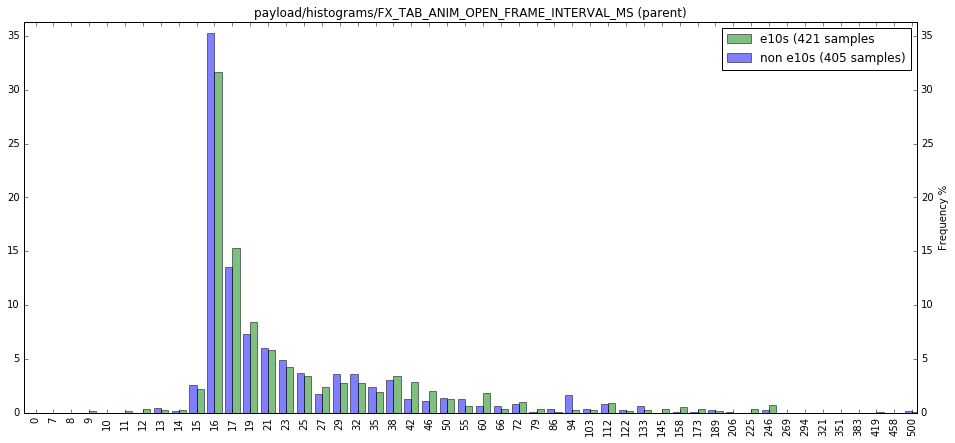

The probability that the distributions for payload/histograms/FX_TAB_ANIM_OPEN_FRAME_INTERVAL_MS (parent) are differing by chance is 0.49.


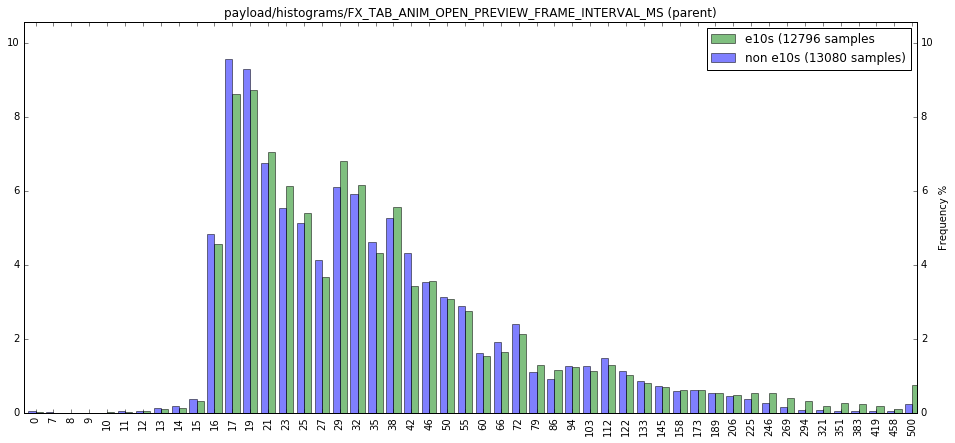

The probability that the distributions for payload/histograms/FX_TAB_ANIM_OPEN_PREVIEW_FRAME_INTERVAL_MS (parent) are differing by chance is 0.00.


In [17]:
compare_histograms(subset,
                   "payload/histograms/FX_TAB_ANIM_ANY_FRAME_INTERVAL_MS",
                   "payload/histograms/FX_TAB_ANIM_OPEN_FRAME_INTERVAL_MS",
                   "payload/histograms/FX_TAB_ANIM_OPEN_PREVIEW_FRAME_INTERVAL_MS")

#### d) Graphics:

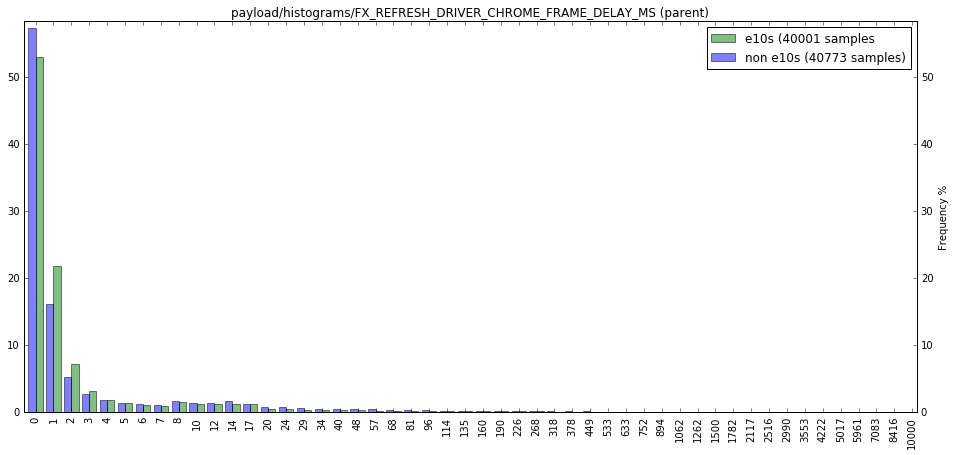

The probability that the distributions for payload/histograms/FX_REFRESH_DRIVER_CHROME_FRAME_DELAY_MS (parent) are differing by chance is 0.00.


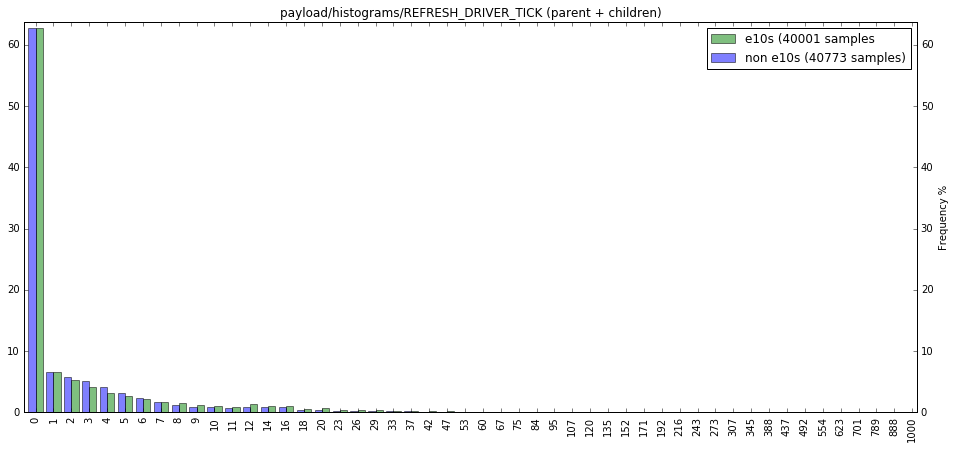

The probability that the distributions for payload/histograms/REFRESH_DRIVER_TICK (parent + children) are differing by chance is 0.00.


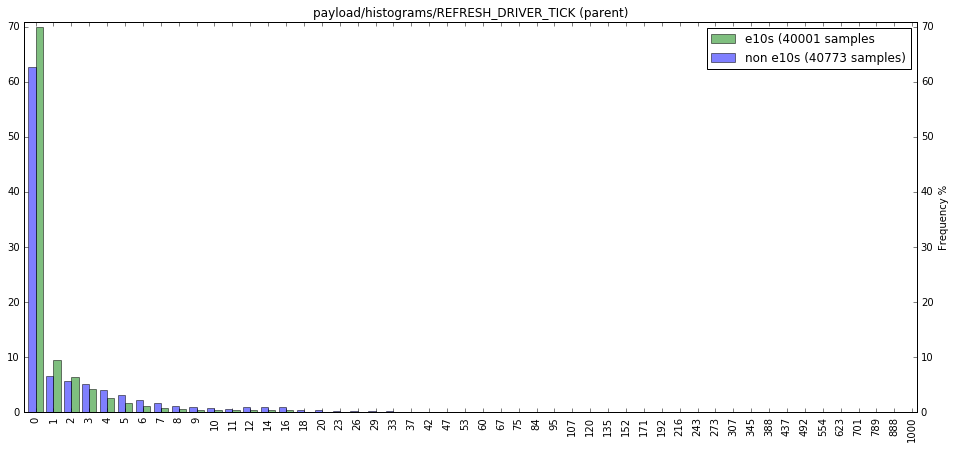

The probability that the distributions for payload/histograms/REFRESH_DRIVER_TICK (parent) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/REFRESH_DRIVER_TICK (children) are differing by chance is 0.00.


In [18]:
compare_histograms(subset, "payload/histograms/REFRESH_DRIVER_TICK",
                           "payload/histograms/FX_REFRESH_DRIVER_CHROME_FRAME_DELAY_MS")

## 2. Responsivness

#### a) Event processing

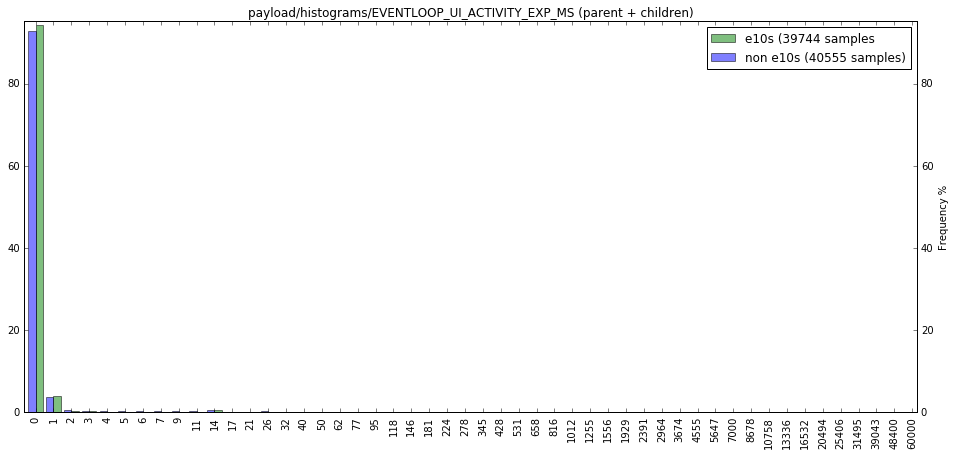

The probability that the distributions for payload/histograms/EVENTLOOP_UI_ACTIVITY_EXP_MS (parent + children) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/EVENTLOOP_UI_ACTIVITY_EXP_MS (parent) are differing by chance is 0.00.


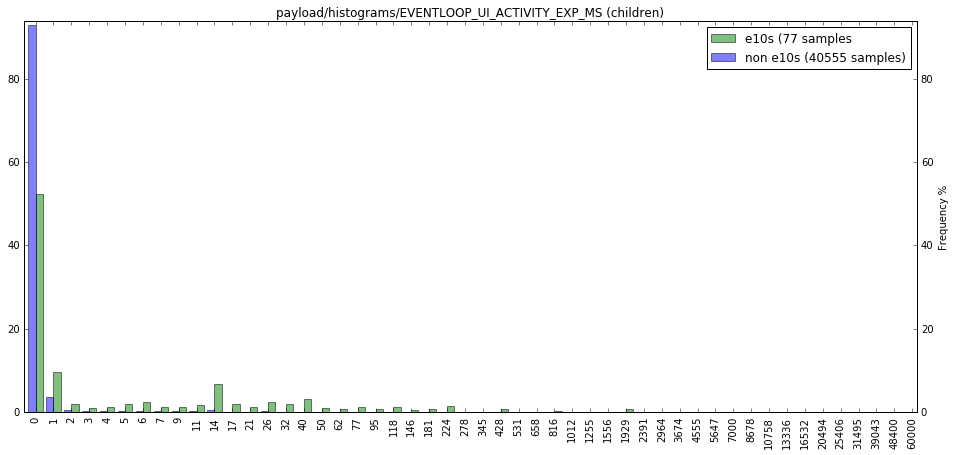

The probability that the distributions for payload/histograms/EVENTLOOP_UI_ACTIVITY_EXP_MS (children) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (parent + children) are differing by chance is 0.00.


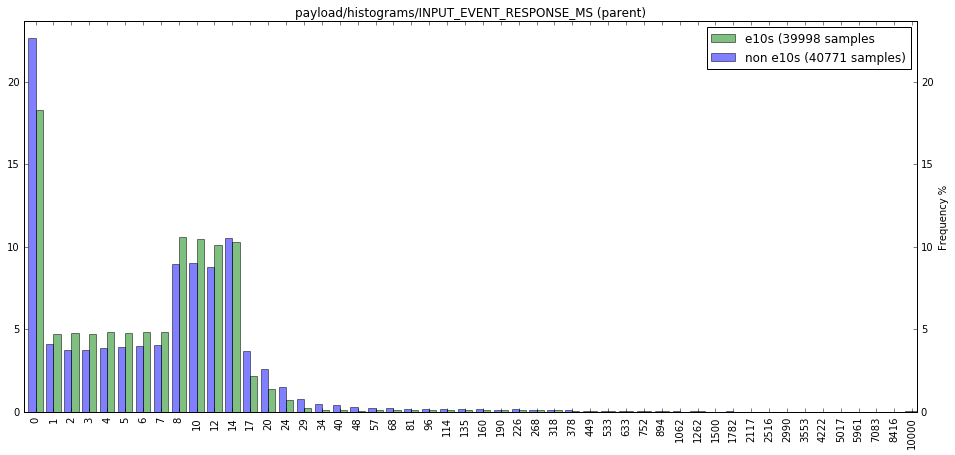

The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (parent) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (children) are differing by chance is 0.00.


In [19]:
compare_histograms(subset, "payload/histograms/EVENTLOOP_UI_ACTIVITY_EXP_MS",
                           "payload/histograms/INPUT_EVENT_RESPONSE_MS")

In [20]:
compare_scalars("hangs over 100ms per minute (parent)",
                eSimple["parent_hangs_per_minute"].dropna(),
                nSimple["parent_hangs_per_minute"].dropna())

Median difference in hangs over 100ms per minute (parent) is -1.77, (0.64, 2.41).
The probability of this effect being purely by chance is 0.00.


In [21]:
compare_scalars("hangs over 100ms per minute (parent + child)",
                (eSimple["child_hangs_per_minute"] + eSimple["parent_hangs_per_minute"]).dropna(),
                nSimple["parent_hangs_per_minute"].dropna())

Median difference in hangs over 100ms per minute (parent + child) is 0.41, (2.83, 2.41).
The probability of this effect being purely by chance is 0.00.


#### b) Plugins

In [22]:
compare_count_histograms(big_subset, "payload/keyedHistograms/SUBPROCESS_ABNORMAL_ABORT/plugin")

Median difference in payload/keyedHistograms/SUBPROCESS_ABNORMAL_ABORT/plugin per hour is -0.02, (0.54, 0.55).
The probability of this effect being purely by chance is 0.68.


#### c) Page load

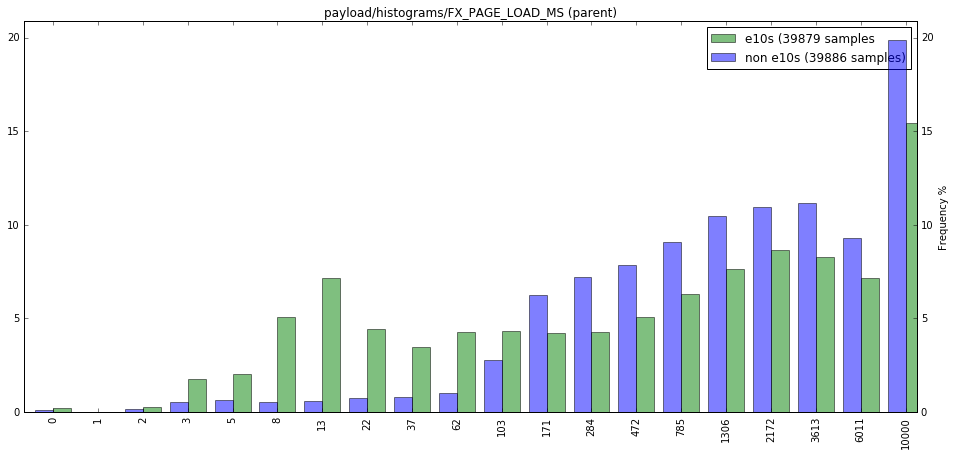

The probability that the distributions for payload/histograms/FX_PAGE_LOAD_MS (parent) are differing by chance is 0.00.


In [23]:
compare_histograms(subset, "payload/histograms/FX_PAGE_LOAD_MS")

#### d) Slow scripts

In [24]:
compare_count_histograms(big_subset, "payload/histograms/SLOW_SCRIPT_NOTICE_COUNT")

Median difference in payload/histograms/SLOW_SCRIPT_NOTICE_COUNT per hour is 0.18, (0.74, 0.55).
The probability of this effect being purely by chance is 0.00.


In [25]:
compare_count_histograms(big_subset, "payload/histograms/SLOW_SCRIPT_PAGE_COUNT")

Median difference in payload/histograms/SLOW_SCRIPT_PAGE_COUNT per hour is -0.10, (0.37, 0.47).
The probability of this effect being purely by chance is 0.00.


#### e) Window open time

In [26]:
compare_histograms(subset, "payload/histograms/FX_NEW_WINDOW_MS")

The probability that the distributions for payload/histograms/FX_NEW_WINDOW_MS (parent) are differing by chance is 1.00.


#### f) Garbage collection

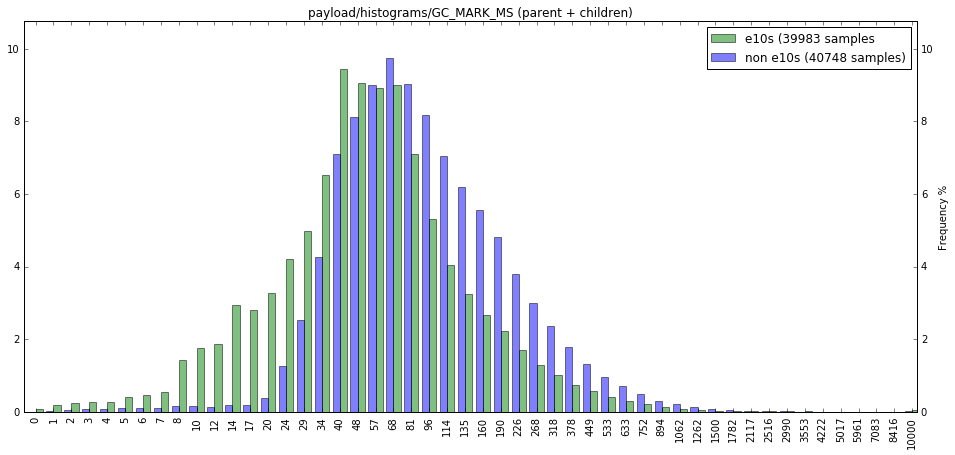

The probability that the distributions for payload/histograms/GC_MARK_MS (parent + children) are differing by chance is 0.00.


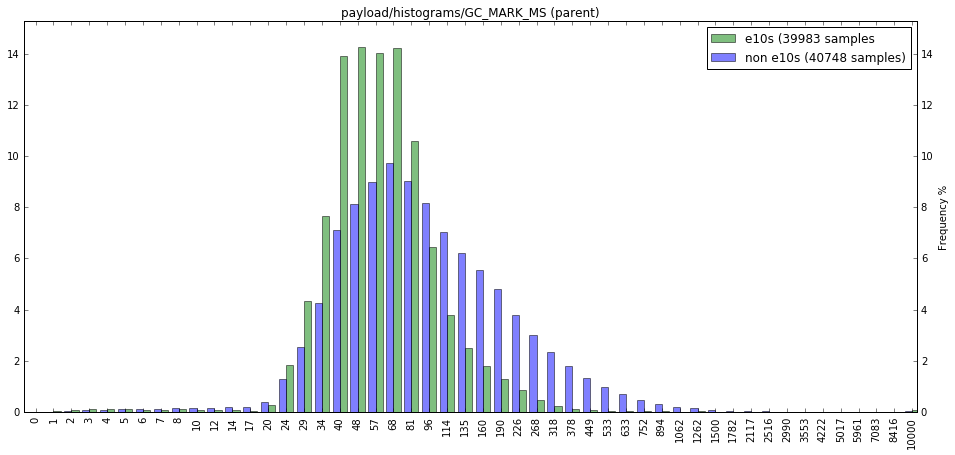

The probability that the distributions for payload/histograms/GC_MARK_MS (parent) are differing by chance is 0.00.


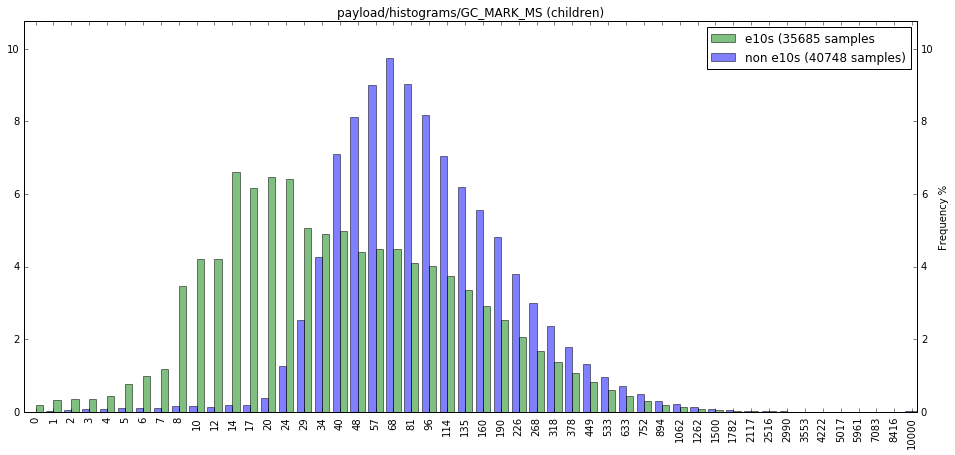

The probability that the distributions for payload/histograms/GC_MARK_MS (children) are differing by chance is 0.00.


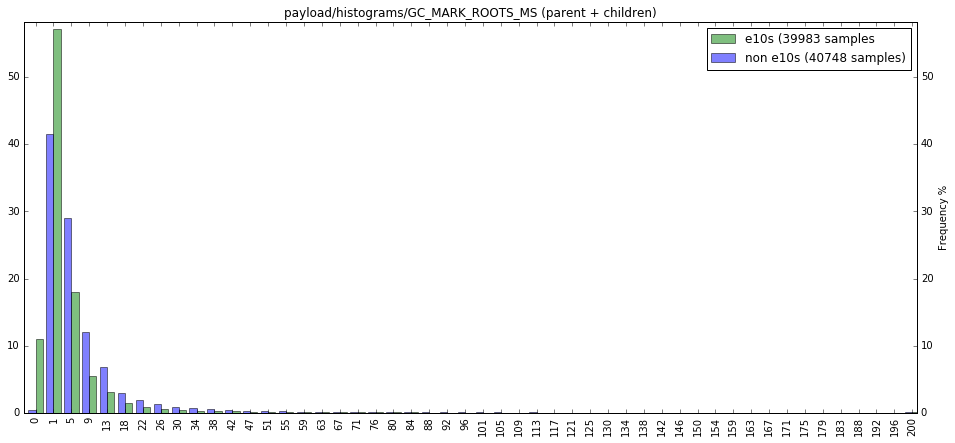

The probability that the distributions for payload/histograms/GC_MARK_ROOTS_MS (parent + children) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/GC_MARK_ROOTS_MS (parent) are differing by chance is 0.00.


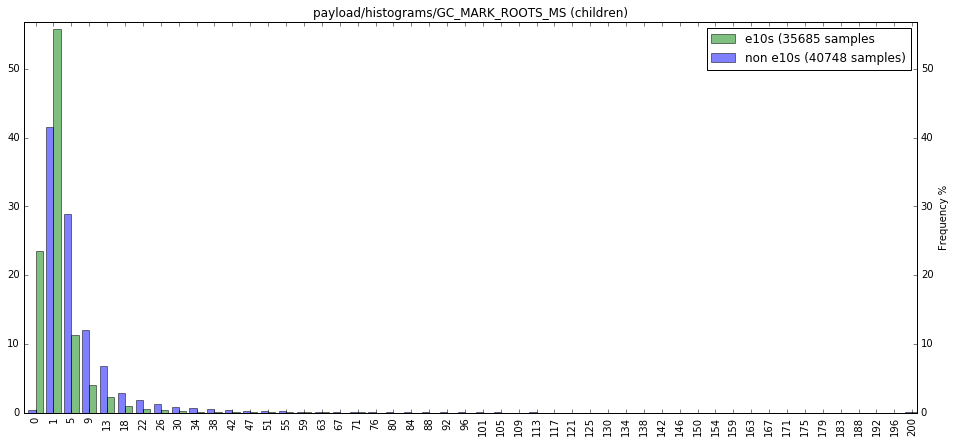

The probability that the distributions for payload/histograms/GC_MARK_ROOTS_MS (children) are differing by chance is 0.00.


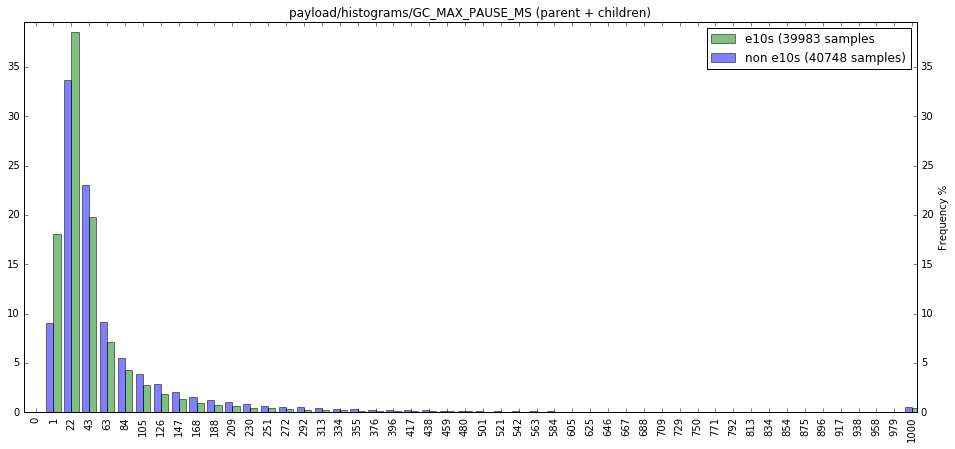

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (parent + children) are differing by chance is 0.00.


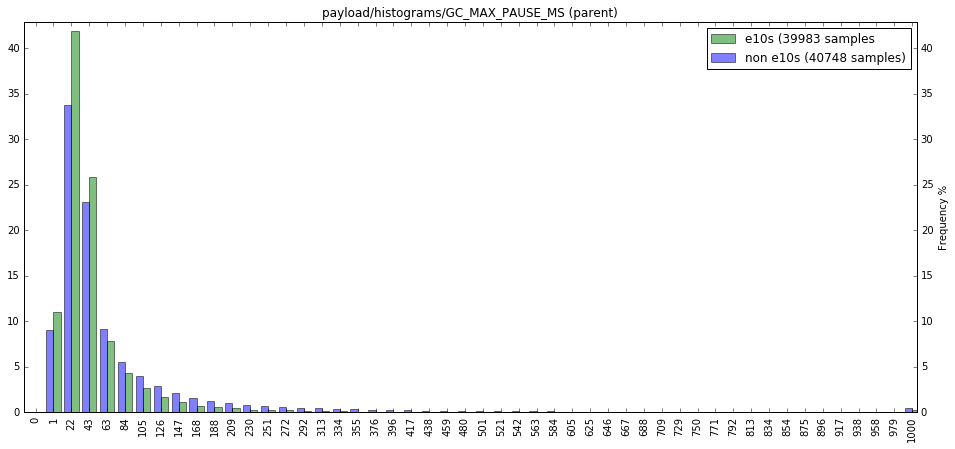

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (parent) are differing by chance is 0.00.


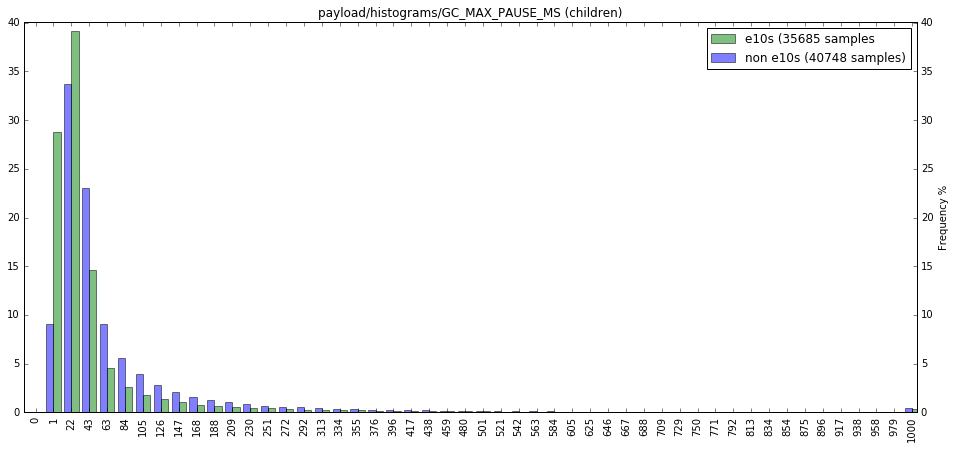

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (children) are differing by chance is 0.00.


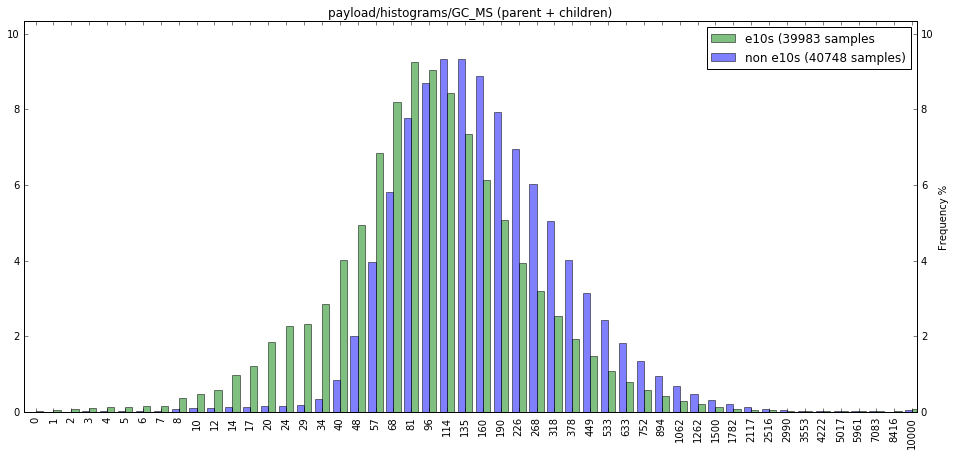

The probability that the distributions for payload/histograms/GC_MS (parent + children) are differing by chance is 0.00.


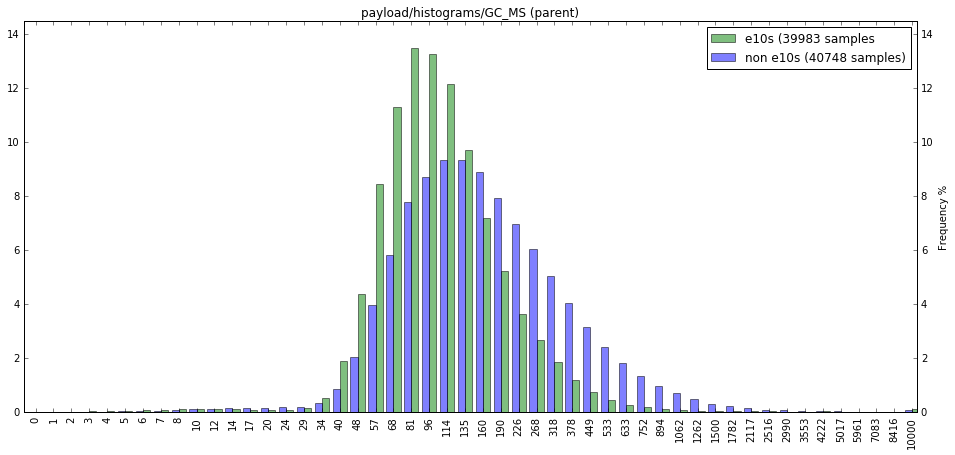

The probability that the distributions for payload/histograms/GC_MS (parent) are differing by chance is 0.00.


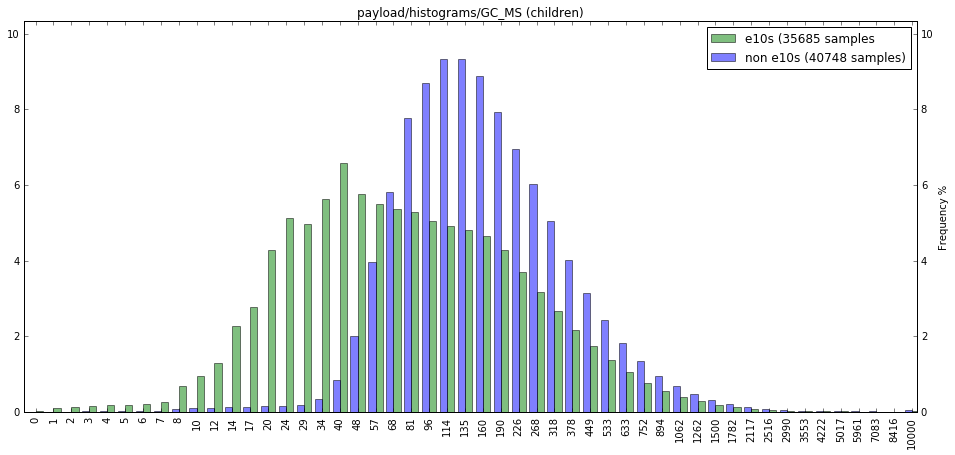

The probability that the distributions for payload/histograms/GC_MS (children) are differing by chance is 0.00.


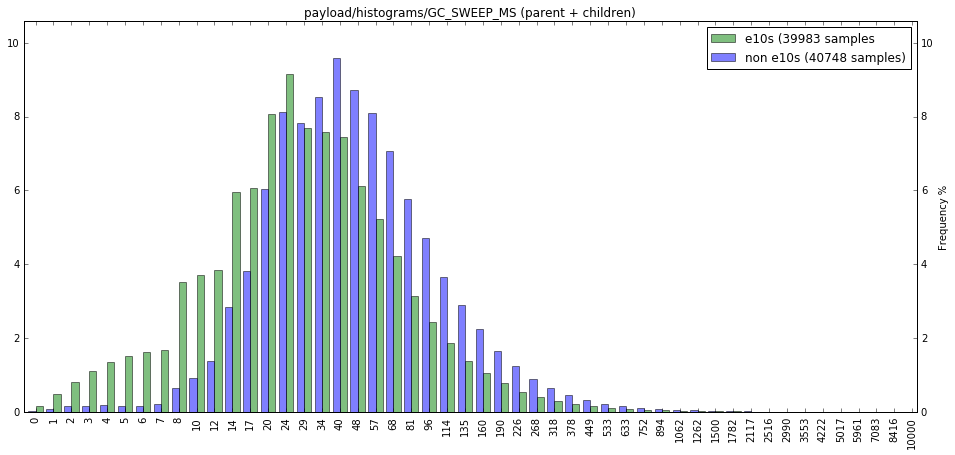

The probability that the distributions for payload/histograms/GC_SWEEP_MS (parent + children) are differing by chance is 0.00.


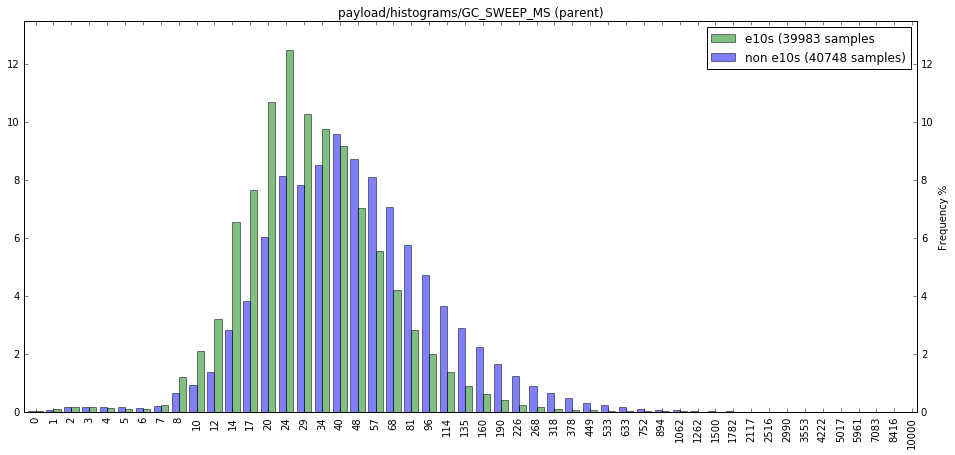

The probability that the distributions for payload/histograms/GC_SWEEP_MS (parent) are differing by chance is 0.00.


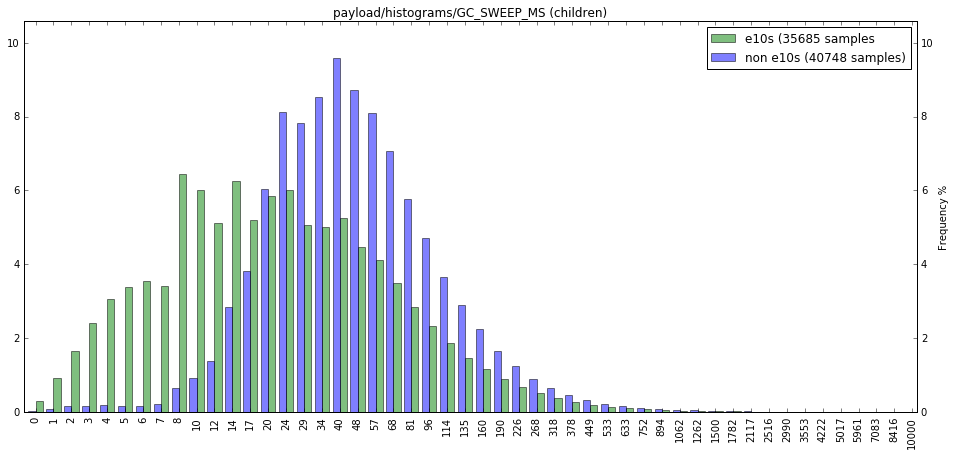

The probability that the distributions for payload/histograms/GC_SWEEP_MS (children) are differing by chance is 0.00.


In [27]:
compare_histograms(subset, 
                   "payload/histograms/GC_MS", 
                   "payload/histograms/GC_MAX_PAUSE_MS", 
                   "payload/histograms/GC_MARK_MS", 
                   "payload/histograms/GC_SWEEP_MS", 
                   "payload/histograms/GC_MARK_ROOTS_MS")

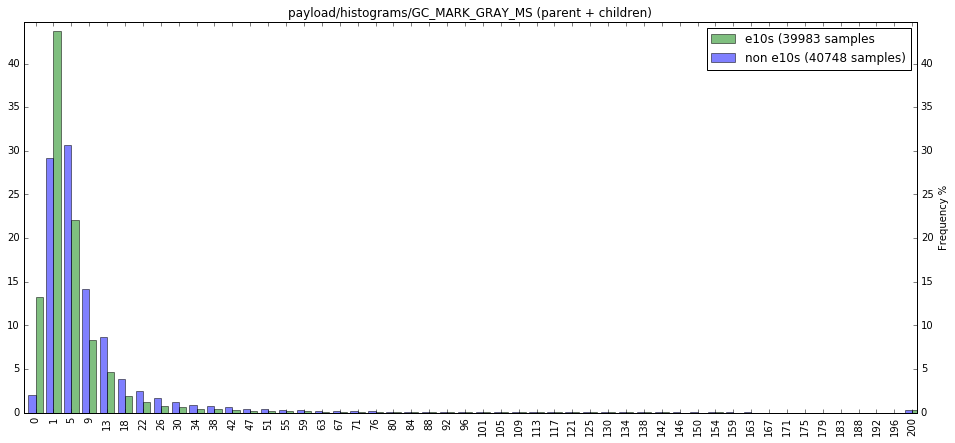

The probability that the distributions for payload/histograms/GC_MARK_GRAY_MS (parent + children) are differing by chance is 0.00.


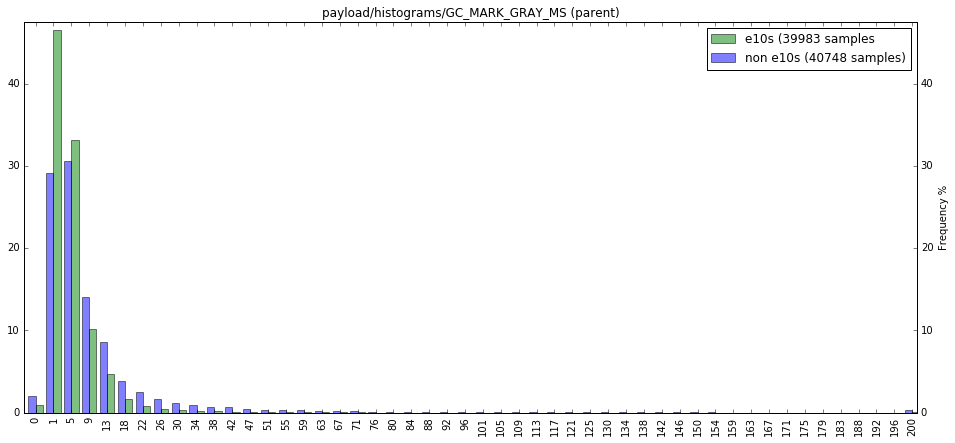

The probability that the distributions for payload/histograms/GC_MARK_GRAY_MS (parent) are differing by chance is 0.00.


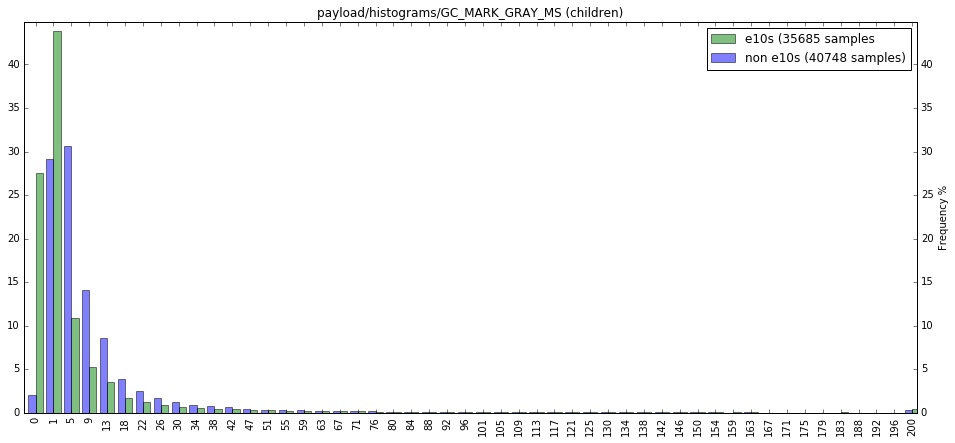

The probability that the distributions for payload/histograms/GC_MARK_GRAY_MS (children) are differing by chance is 0.00.


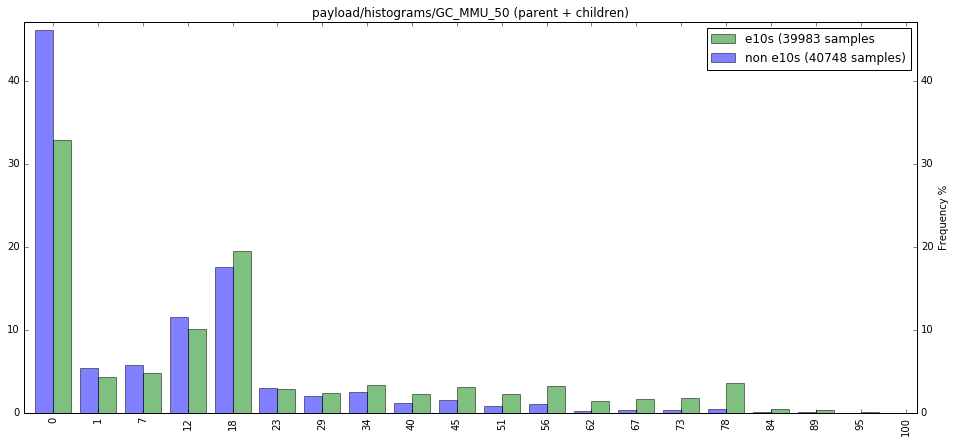

The probability that the distributions for payload/histograms/GC_MMU_50 (parent + children) are differing by chance is 0.00.


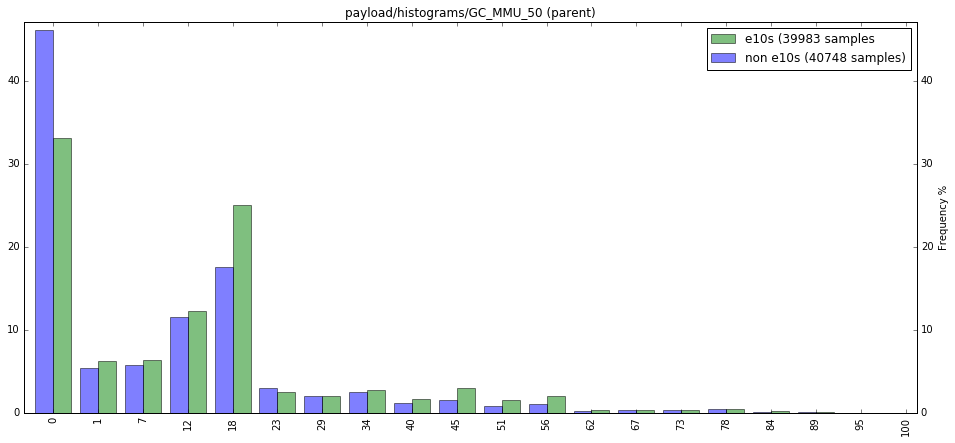

The probability that the distributions for payload/histograms/GC_MMU_50 (parent) are differing by chance is 0.00.


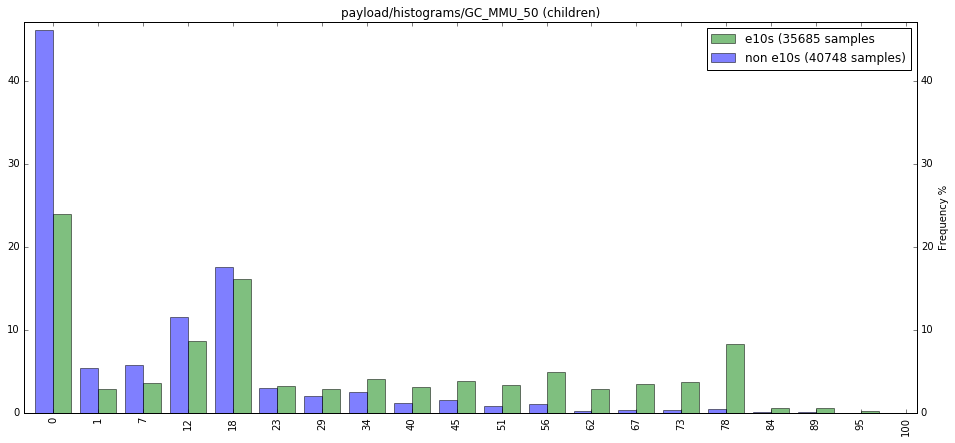

The probability that the distributions for payload/histograms/GC_MMU_50 (children) are differing by chance is 0.00.


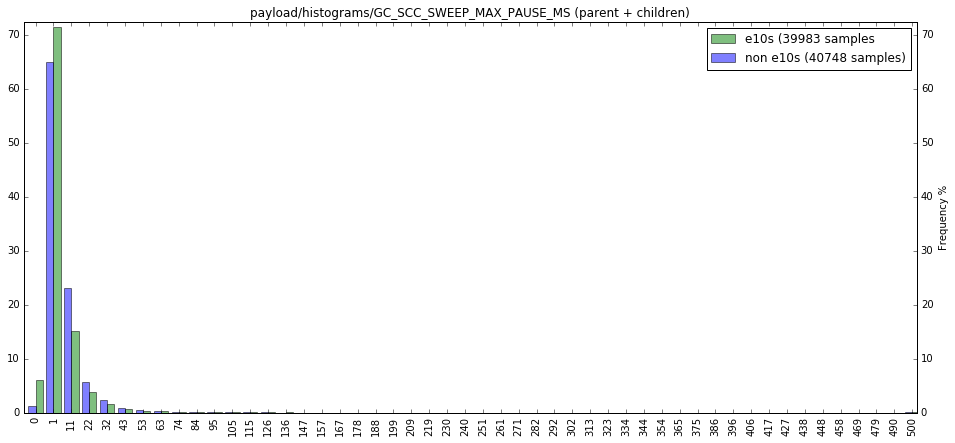

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS (parent + children) are differing by chance is 0.00.


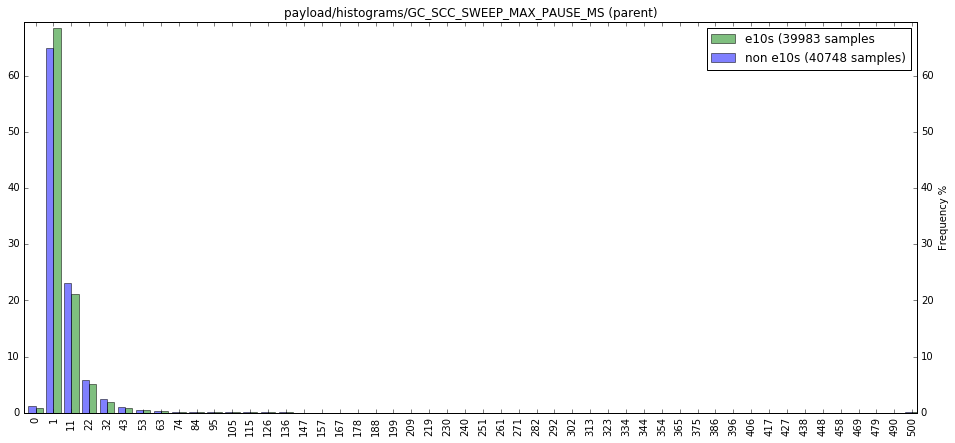

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS (parent) are differing by chance is 0.00.


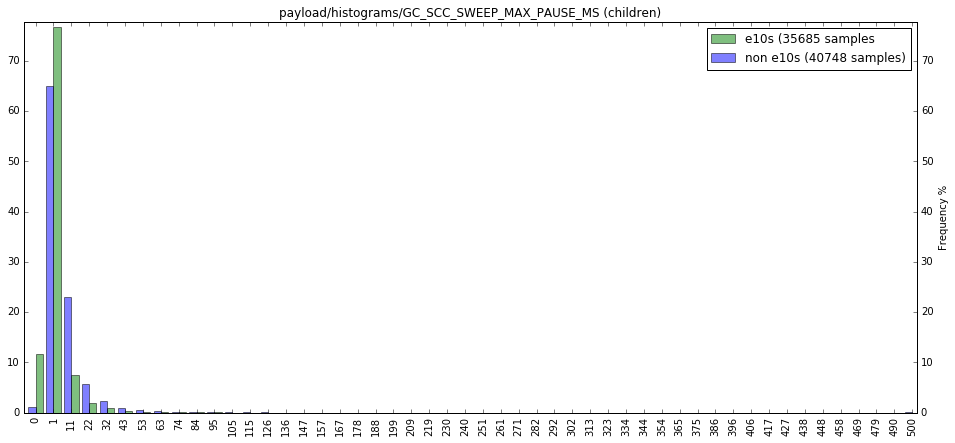

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS (children) are differing by chance is 0.00.


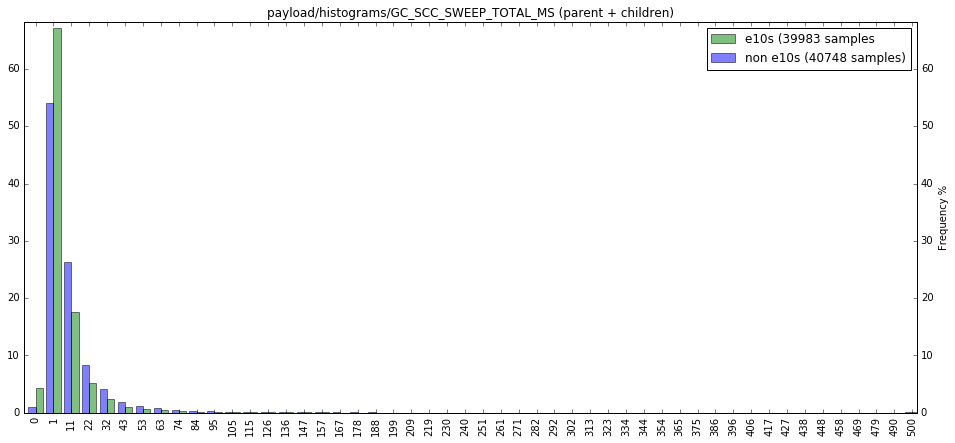

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_TOTAL_MS (parent + children) are differing by chance is 0.00.


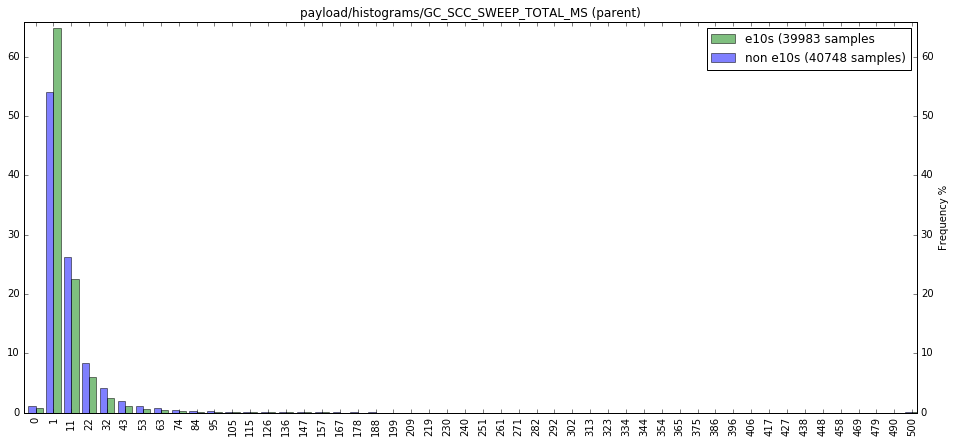

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_TOTAL_MS (parent) are differing by chance is 0.00.


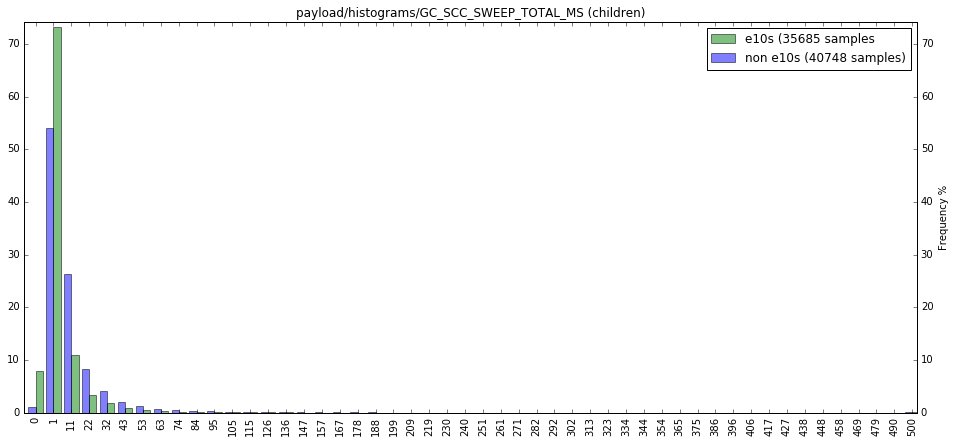

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_TOTAL_MS (children) are differing by chance is 0.00.


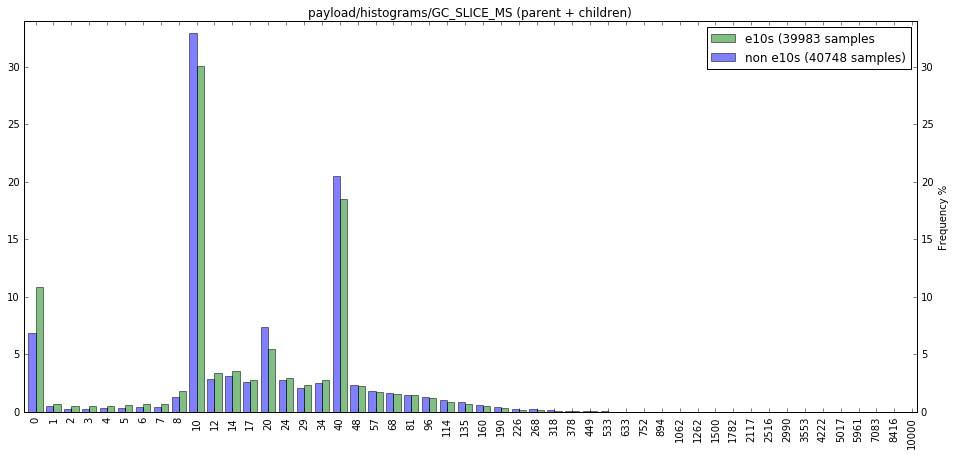

The probability that the distributions for payload/histograms/GC_SLICE_MS (parent + children) are differing by chance is 0.00.


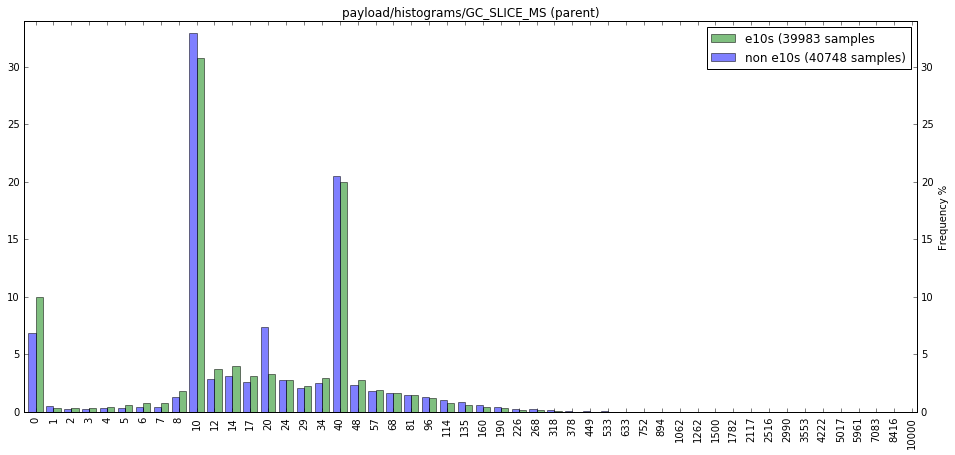

The probability that the distributions for payload/histograms/GC_SLICE_MS (parent) are differing by chance is 0.00.


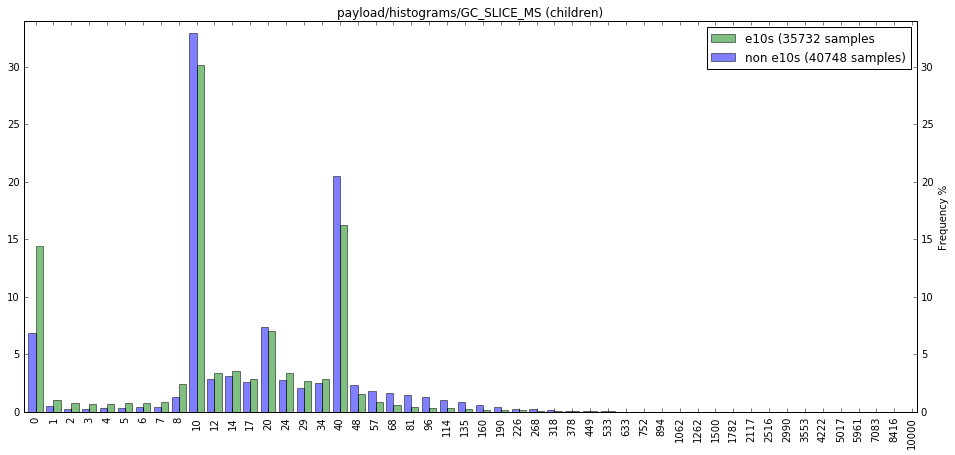

The probability that the distributions for payload/histograms/GC_SLICE_MS (children) are differing by chance is 0.00.


In [28]:
compare_histograms(subset,
                   "payload/histograms/GC_MMU_50",
                   "payload/histograms/GC_MARK_GRAY_MS",
                   "payload/histograms/GC_SLICE_MS",
                   "payload/histograms/GC_SCC_SWEEP_TOTAL_MS",
                   "payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS")

#### g) Cycle Collector

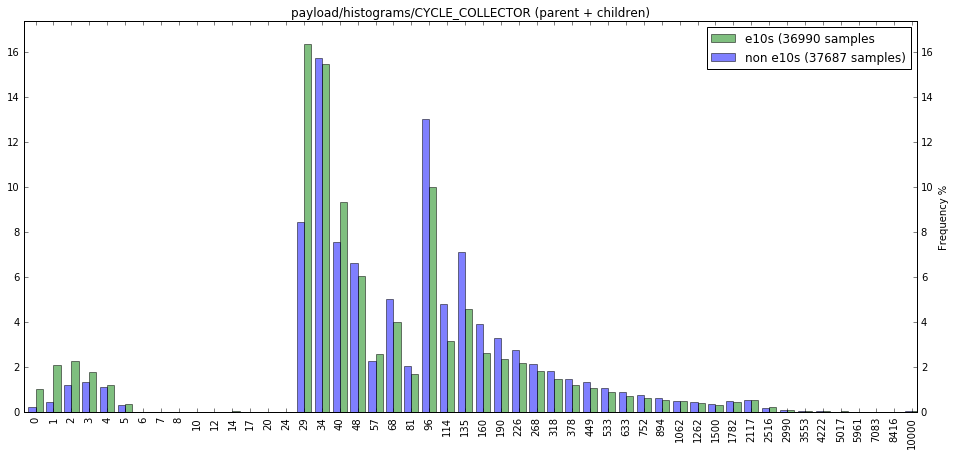

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR (parent + children) are differing by chance is 0.00.


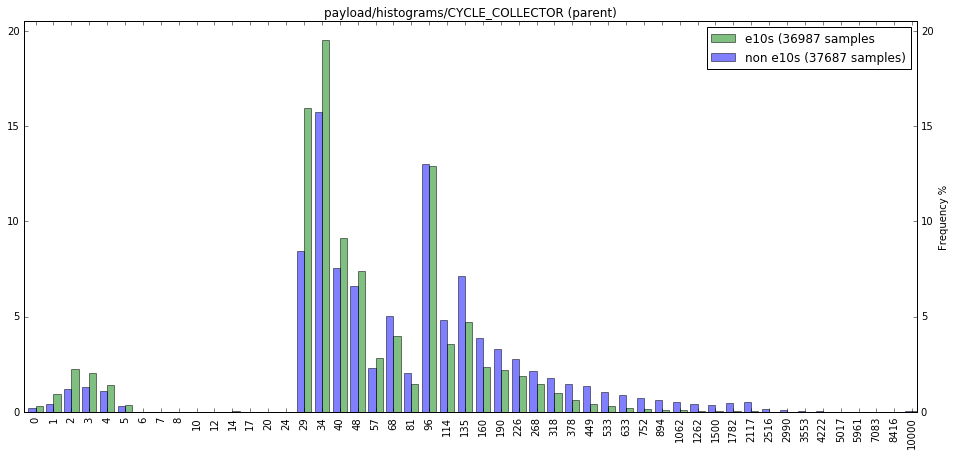

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR (parent) are differing by chance is 0.00.


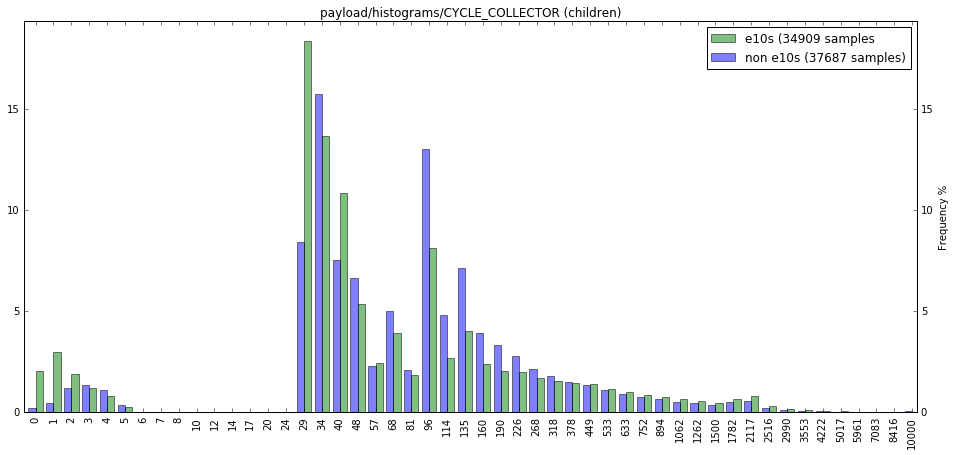

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR (children) are differing by chance is 0.00.


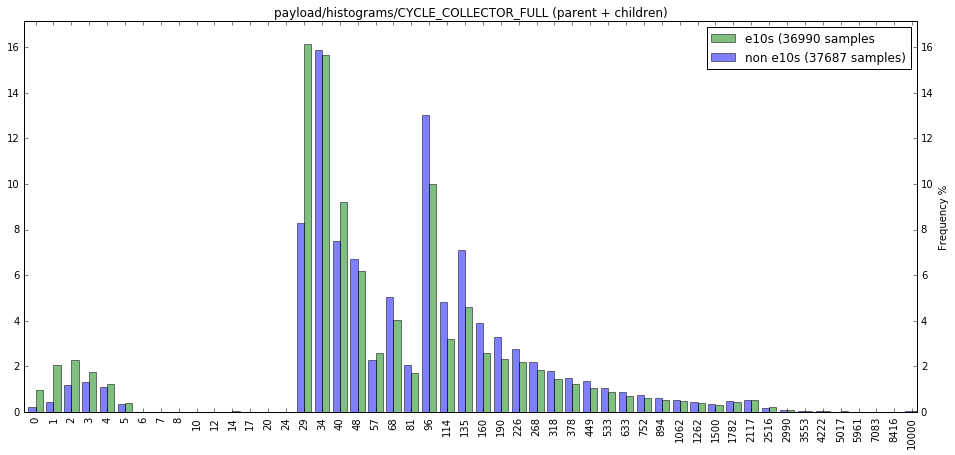

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_FULL (parent + children) are differing by chance is 0.00.


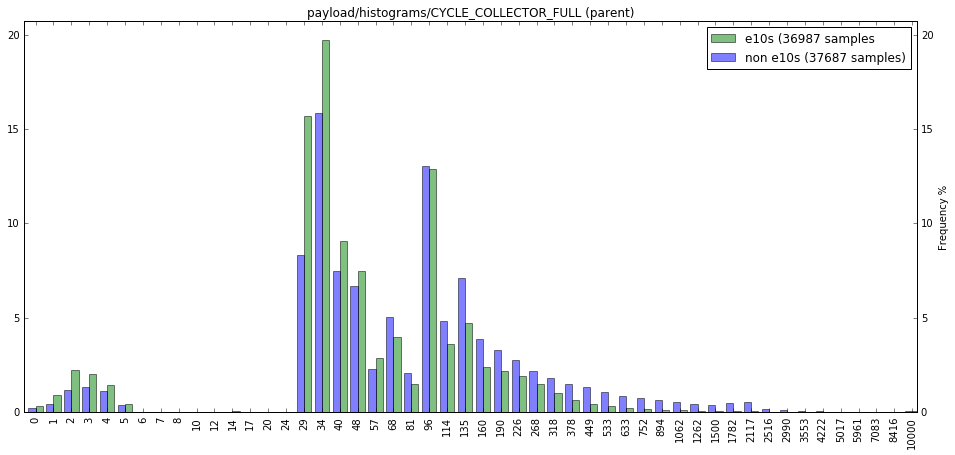

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_FULL (parent) are differing by chance is 0.00.


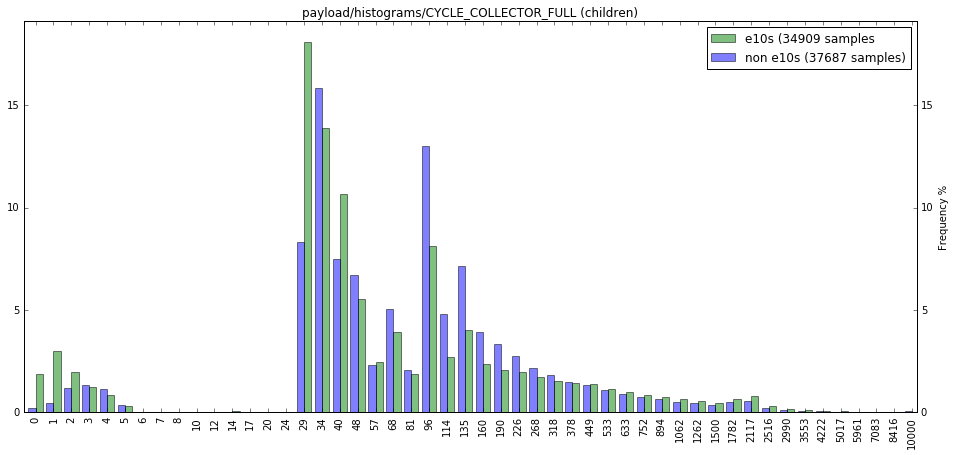

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_FULL (children) are differing by chance is 0.00.


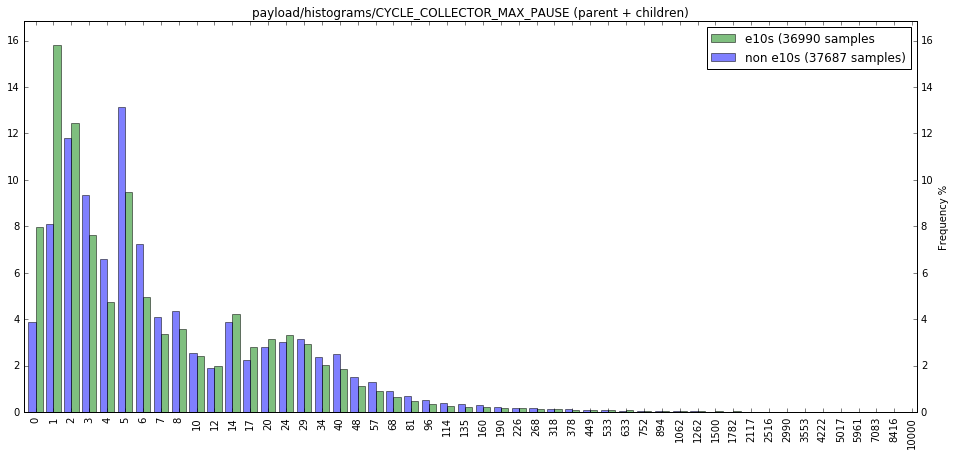

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (parent + children) are differing by chance is 0.00.


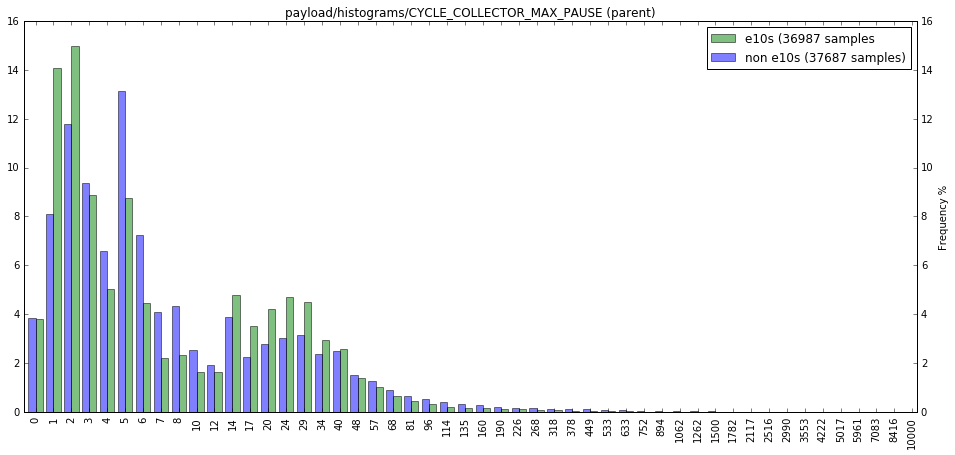

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (parent) are differing by chance is 0.00.


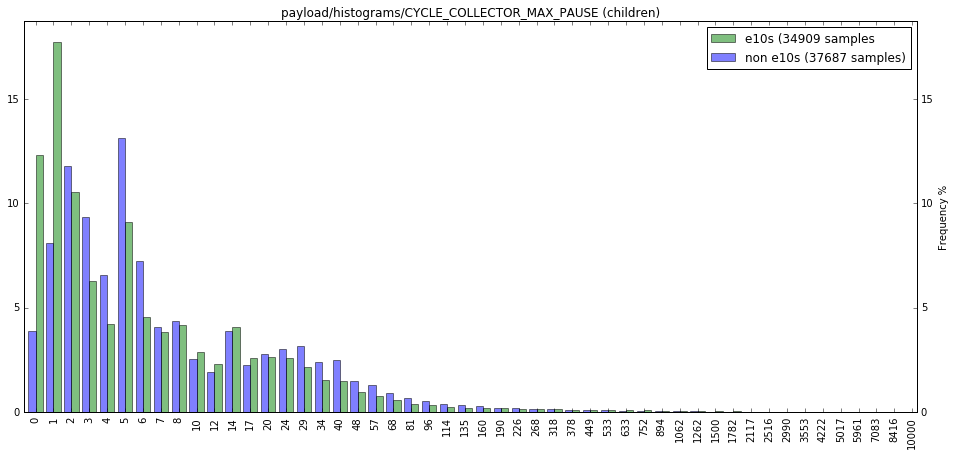

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (children) are differing by chance is 0.00.


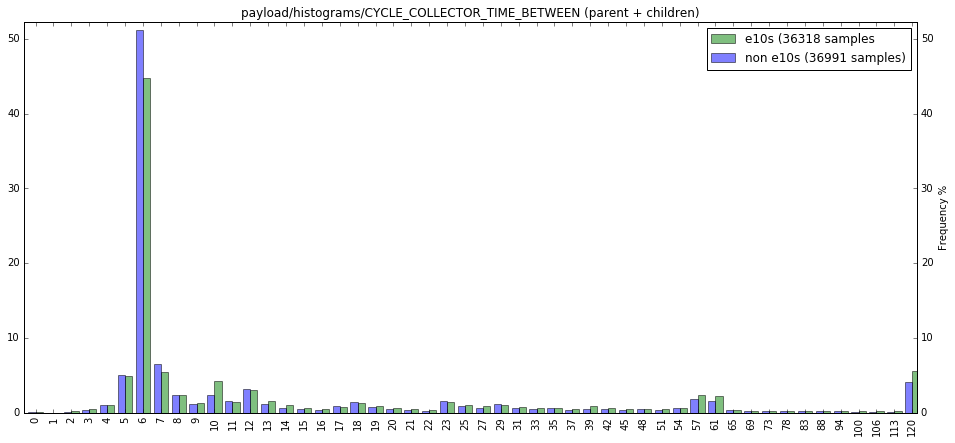

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN (parent + children) are differing by chance is 0.00.


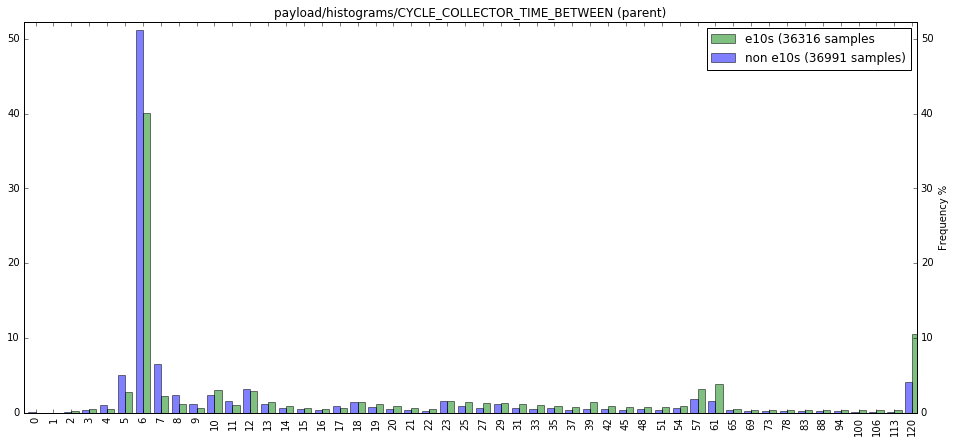

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN (parent) are differing by chance is 0.00.


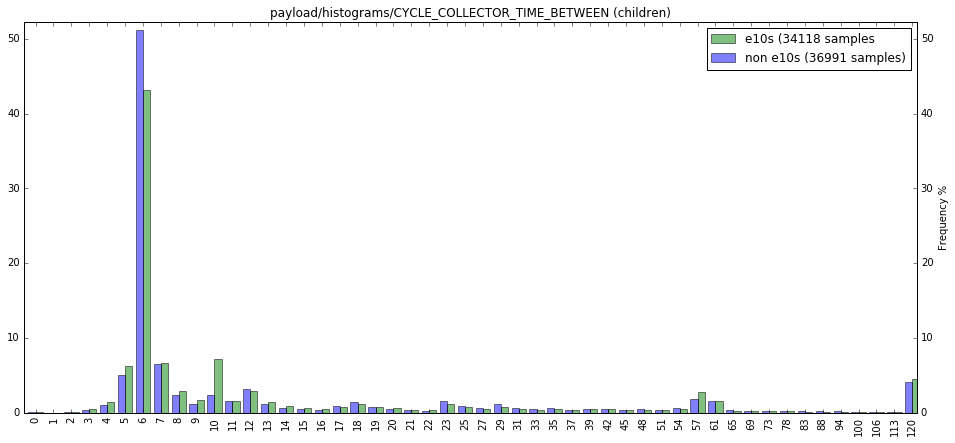

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN (children) are differing by chance is 0.00.


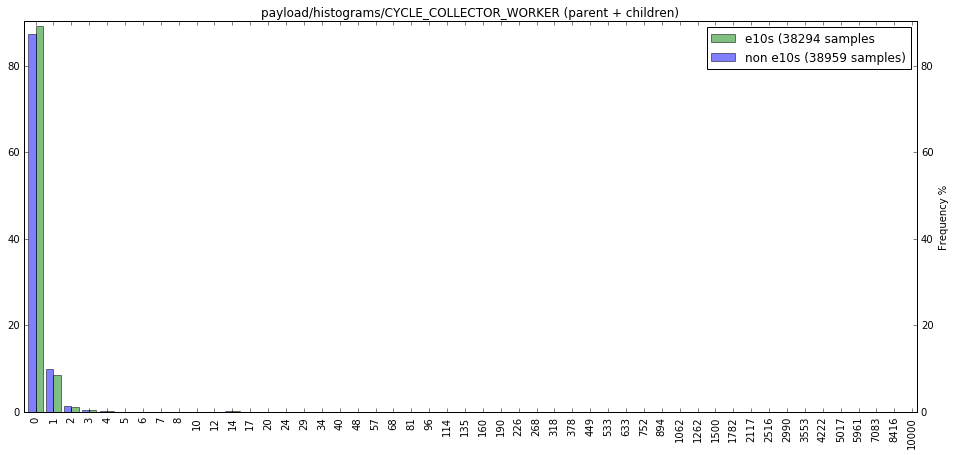

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_WORKER (parent + children) are differing by chance is 0.00.


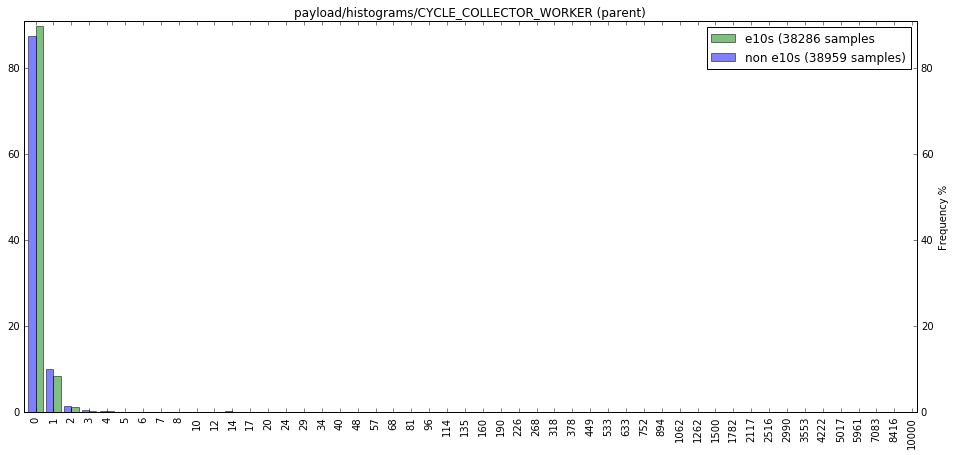

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_WORKER (parent) are differing by chance is 0.00.


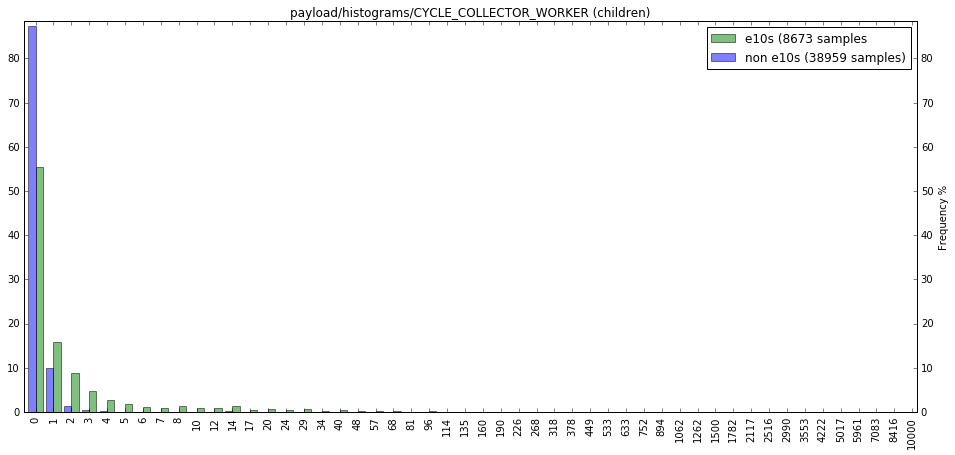

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_WORKER (children) are differing by chance is 0.00.


In [29]:
compare_histograms(subset,
                   "payload/histograms/CYCLE_COLLECTOR",
                   "payload/histograms/CYCLE_COLLECTOR_WORKER",
                   "payload/histograms/CYCLE_COLLECTOR_FULL",
                   "payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE",
                   "payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN")

## 3. Memory

#### a) Usage (bytes)

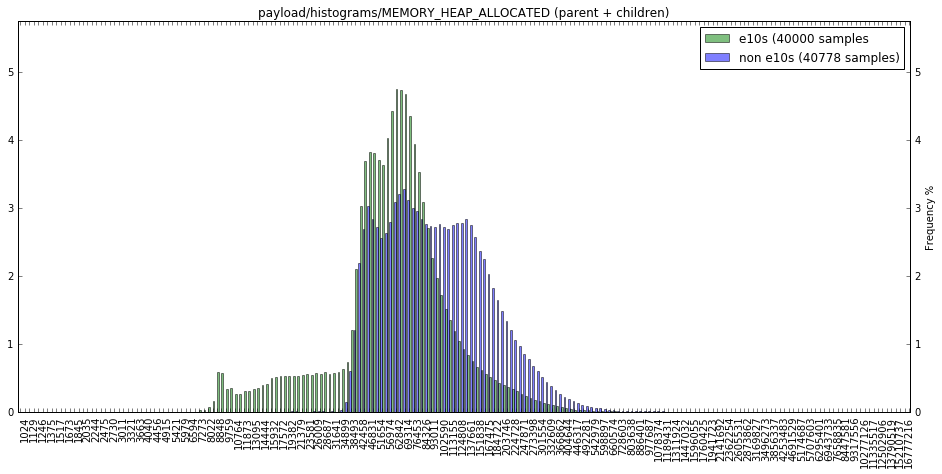

The probability that the distributions for payload/histograms/MEMORY_HEAP_ALLOCATED (parent + children) are differing by chance is 0.00.


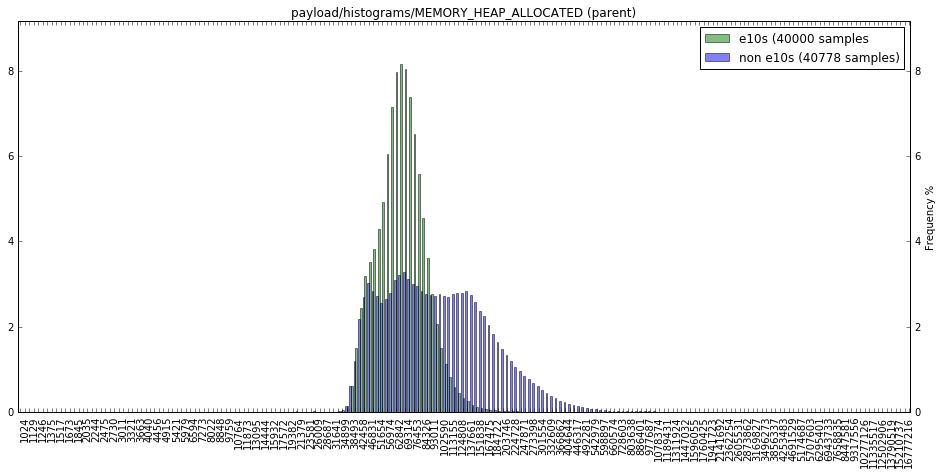

The probability that the distributions for payload/histograms/MEMORY_HEAP_ALLOCATED (parent) are differing by chance is 0.00.


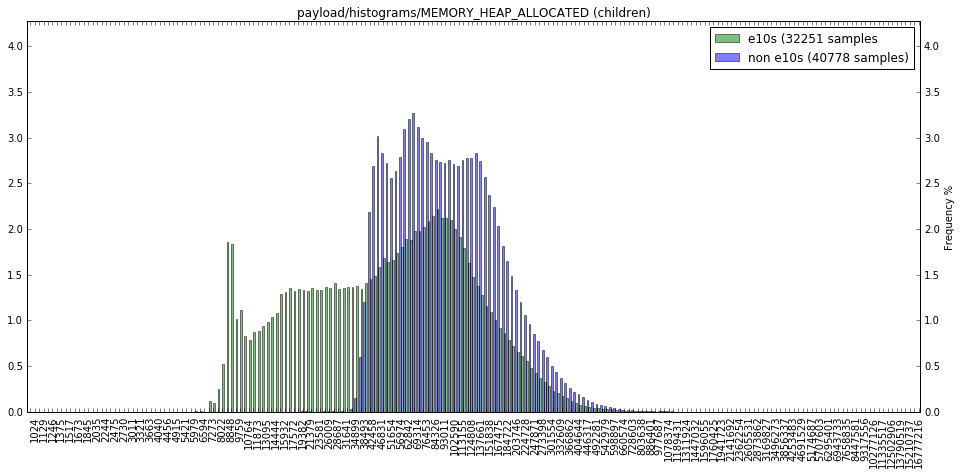

The probability that the distributions for payload/histograms/MEMORY_HEAP_ALLOCATED (children) are differing by chance is 0.00.


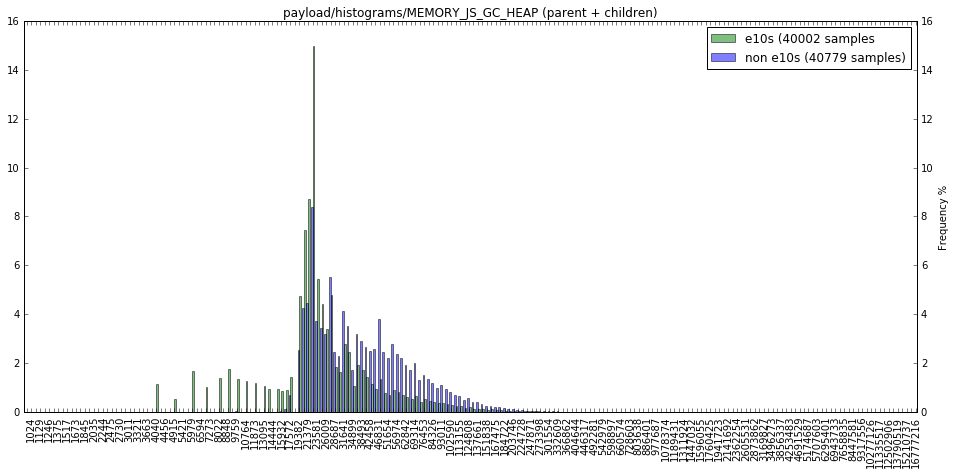

The probability that the distributions for payload/histograms/MEMORY_JS_GC_HEAP (parent + children) are differing by chance is 0.00.


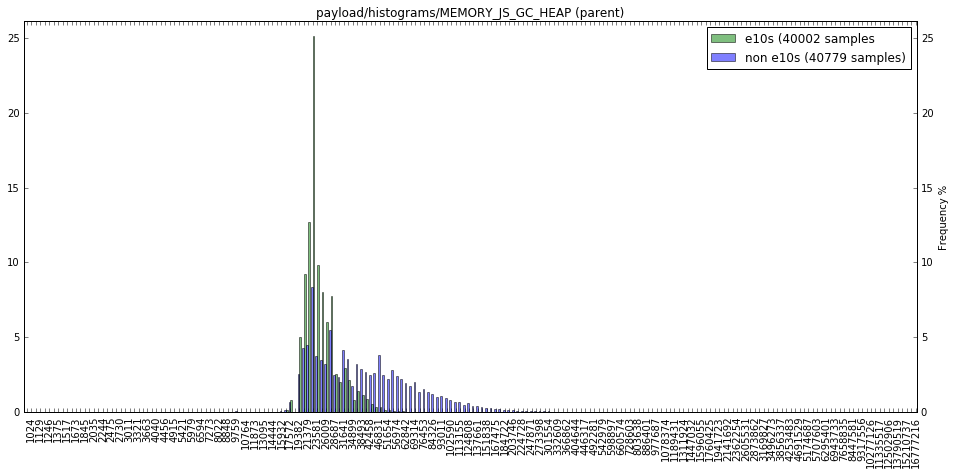

The probability that the distributions for payload/histograms/MEMORY_JS_GC_HEAP (parent) are differing by chance is 0.00.


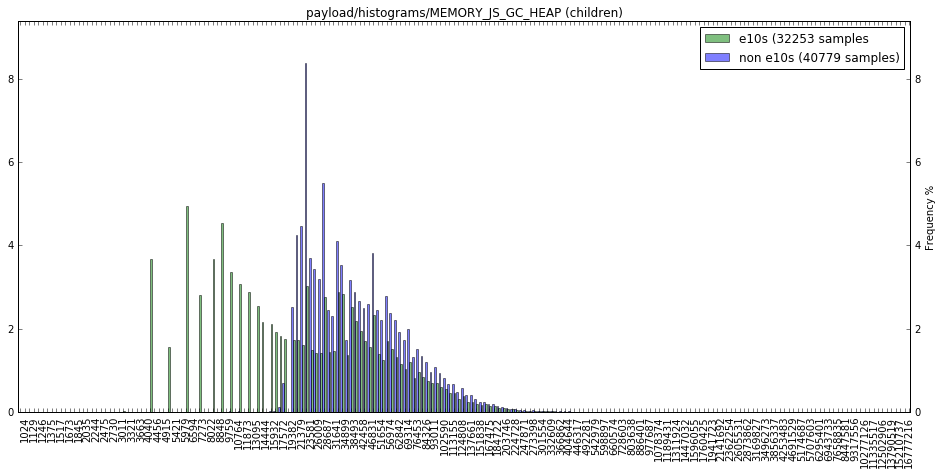

The probability that the distributions for payload/histograms/MEMORY_JS_GC_HEAP (children) are differing by chance is 0.00.


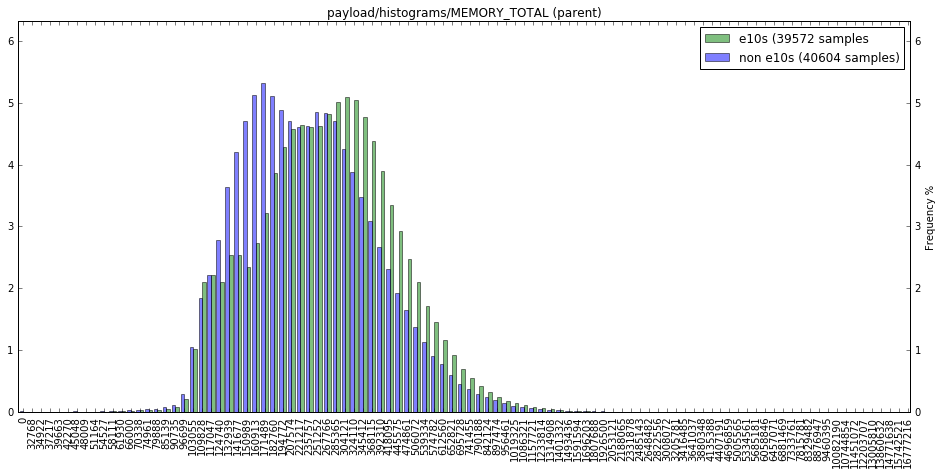

The probability that the distributions for payload/histograms/MEMORY_TOTAL (parent) are differing by chance is 0.00.


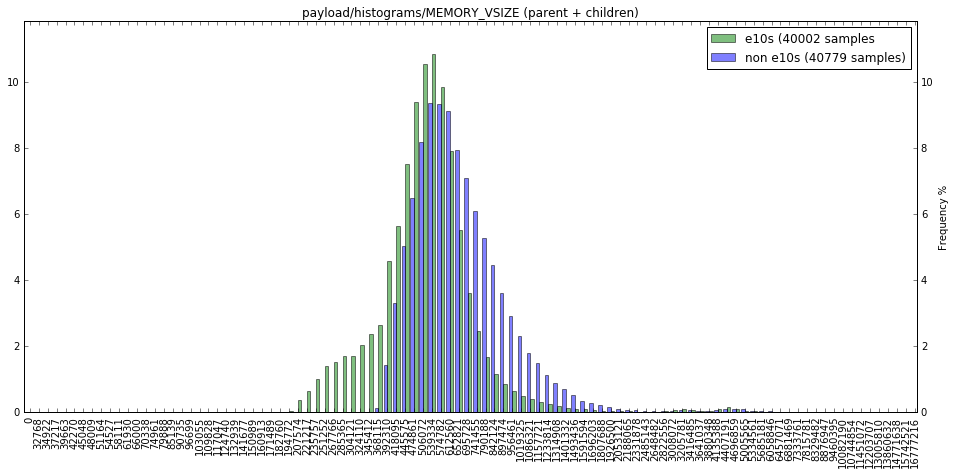

The probability that the distributions for payload/histograms/MEMORY_VSIZE (parent + children) are differing by chance is 0.00.


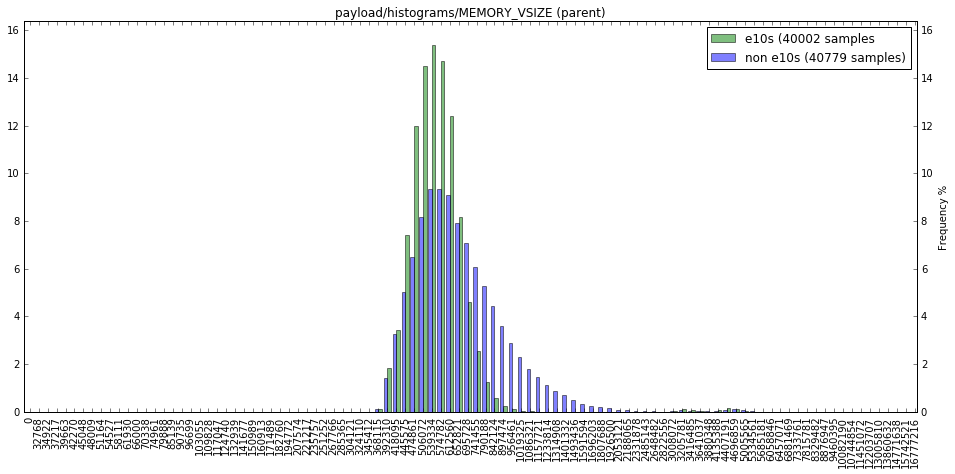

The probability that the distributions for payload/histograms/MEMORY_VSIZE (parent) are differing by chance is 0.00.


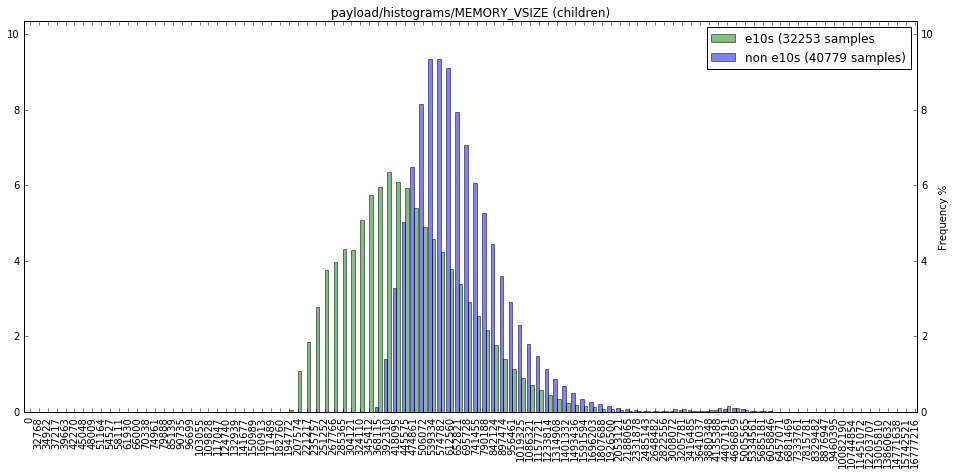

The probability that the distributions for payload/histograms/MEMORY_VSIZE (children) are differing by chance is 0.00.


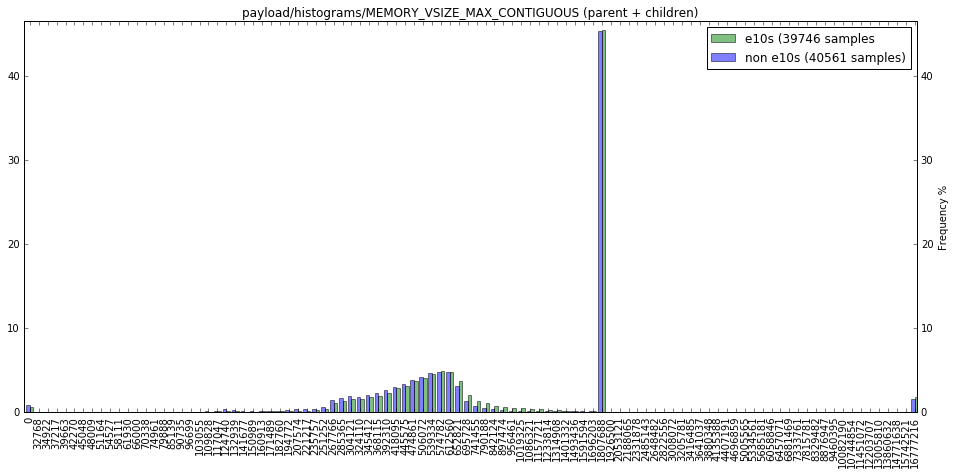

The probability that the distributions for payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS (parent + children) are differing by chance is 0.00.


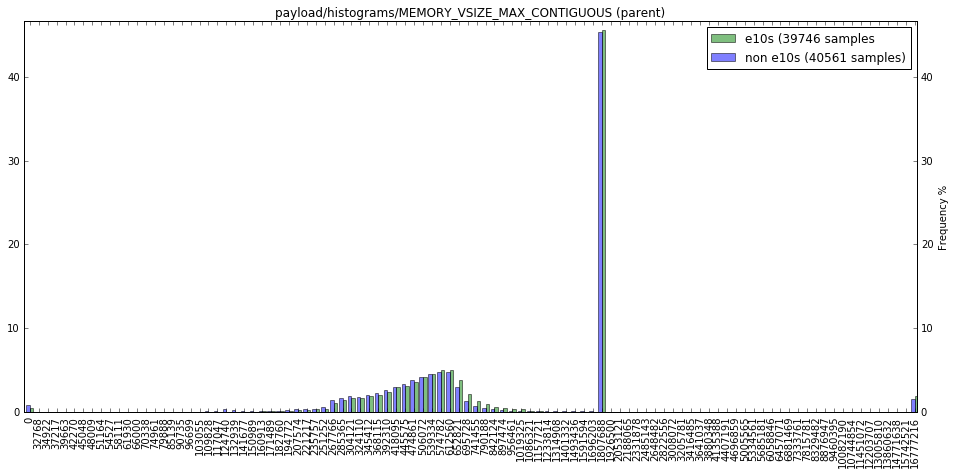

The probability that the distributions for payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS (parent) are differing by chance is 0.00.


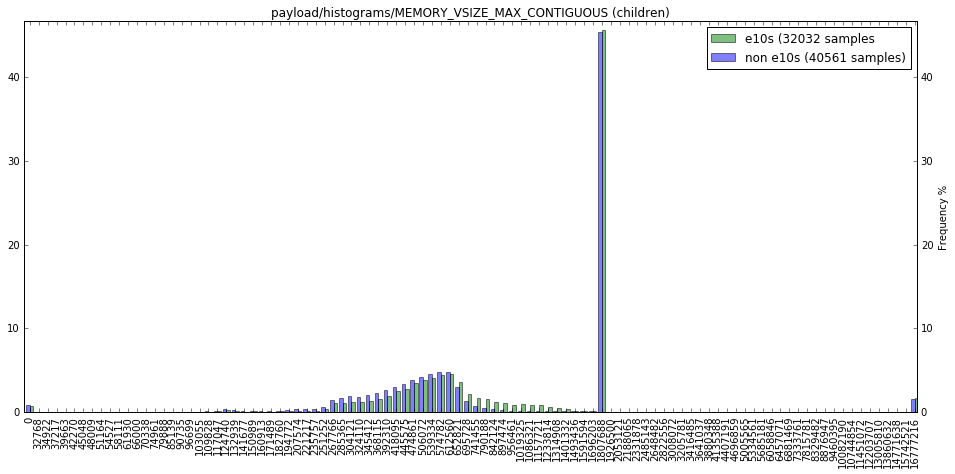

The probability that the distributions for payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS (children) are differing by chance is 0.00.


In [30]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_TOTAL",
                   "payload/histograms/MEMORY_VSIZE",
                   "payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS",
                   "payload/histograms/MEMORY_HEAP_ALLOCATED",
                   "payload/histograms/MEMORY_JS_GC_HEAP")

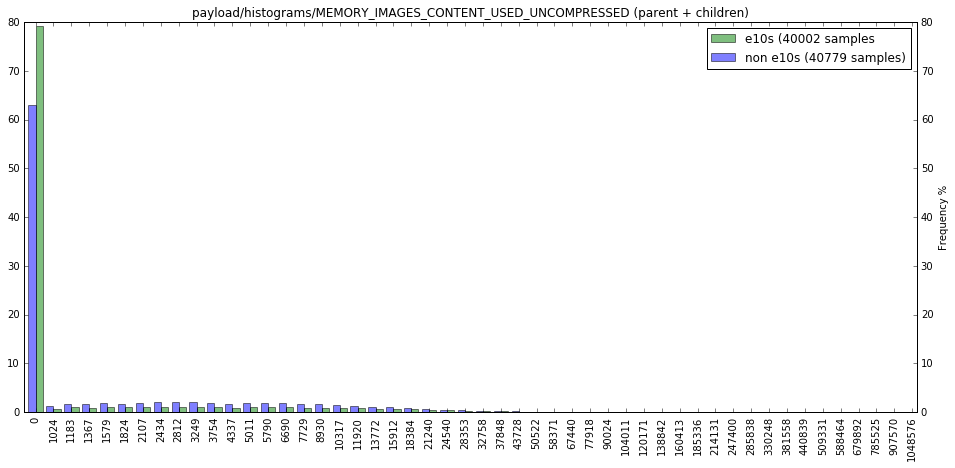

The probability that the distributions for payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED (parent + children) are differing by chance is 0.00.


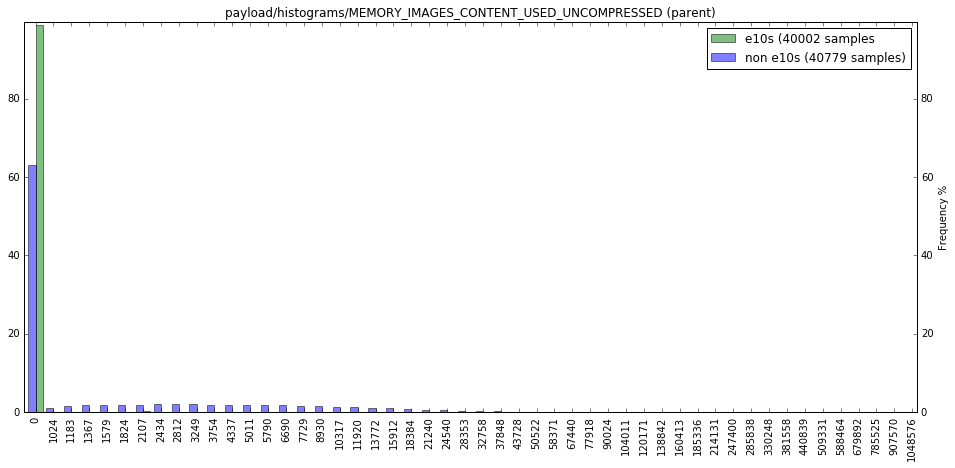

The probability that the distributions for payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED (parent) are differing by chance is 0.00.


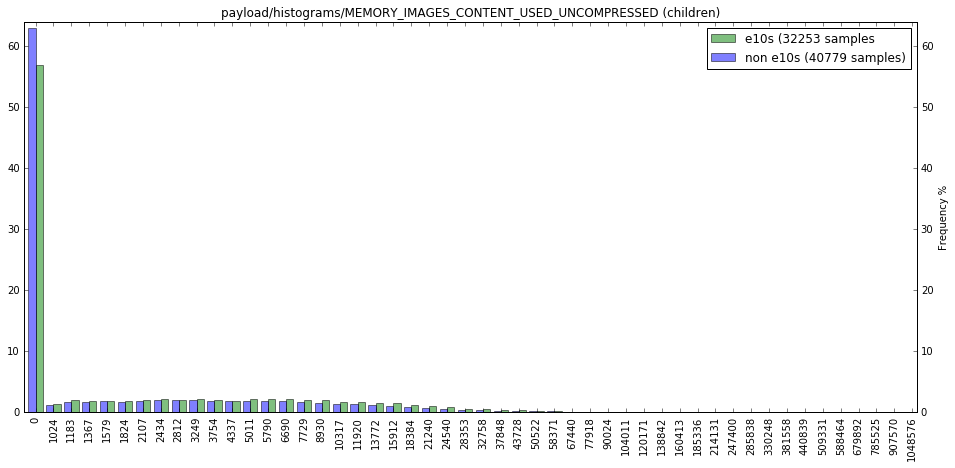

The probability that the distributions for payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED (children) are differing by chance is 0.00.


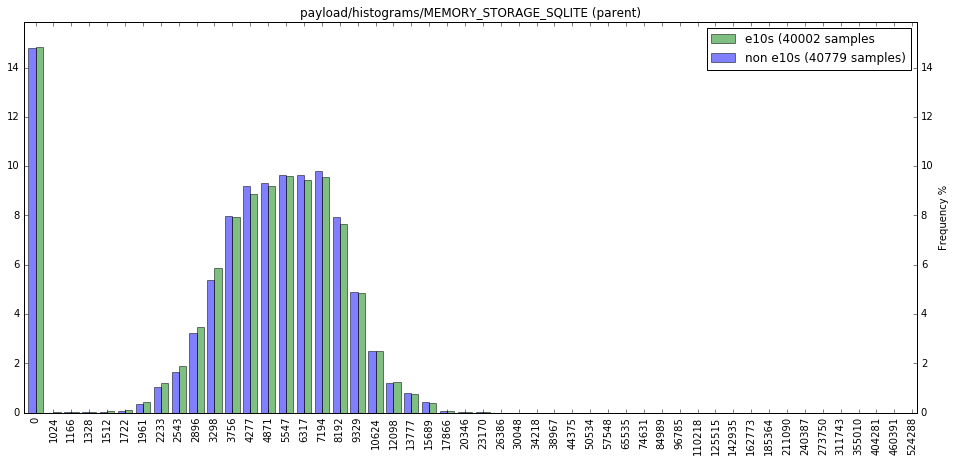

The probability that the distributions for payload/histograms/MEMORY_STORAGE_SQLITE (parent) are differing by chance is 0.00.


In [11]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED",
                   "payload/histograms/MEMORY_STORAGE_SQLITE")

#### c) JS compartments

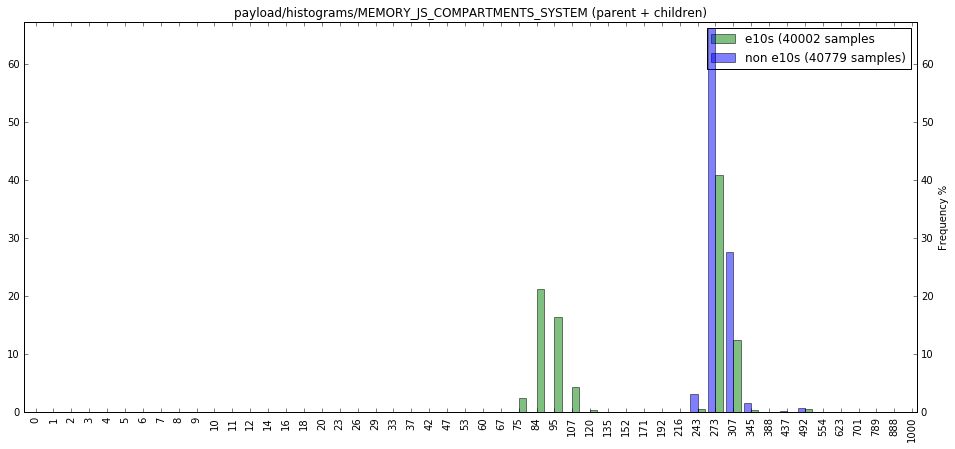

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM (parent + children) are differing by chance is 0.00.


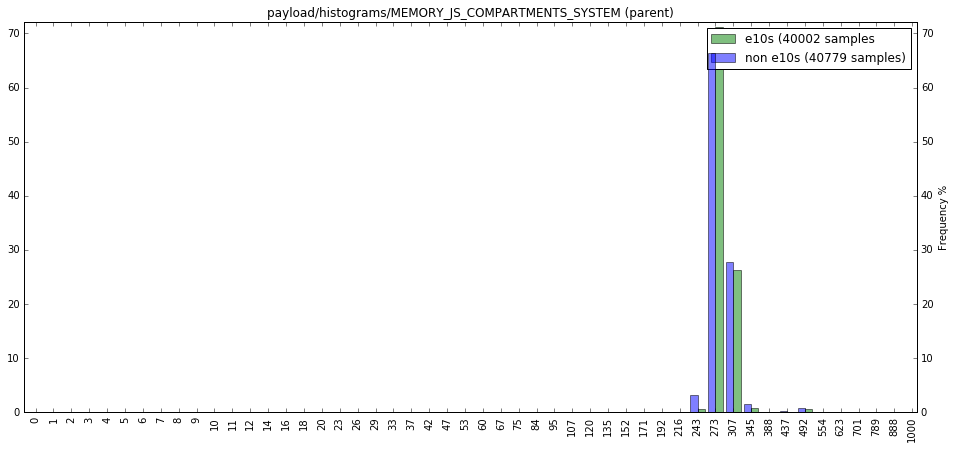

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM (parent) are differing by chance is 0.00.


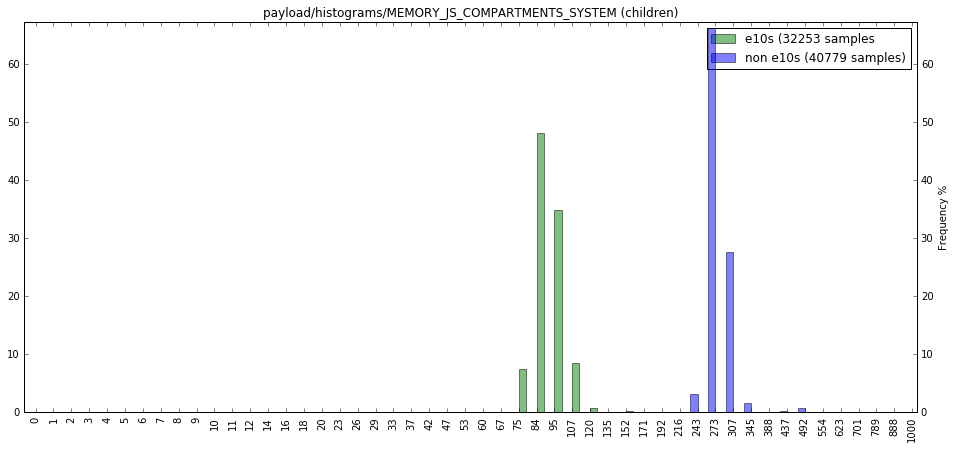

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM (children) are differing by chance is 0.00.


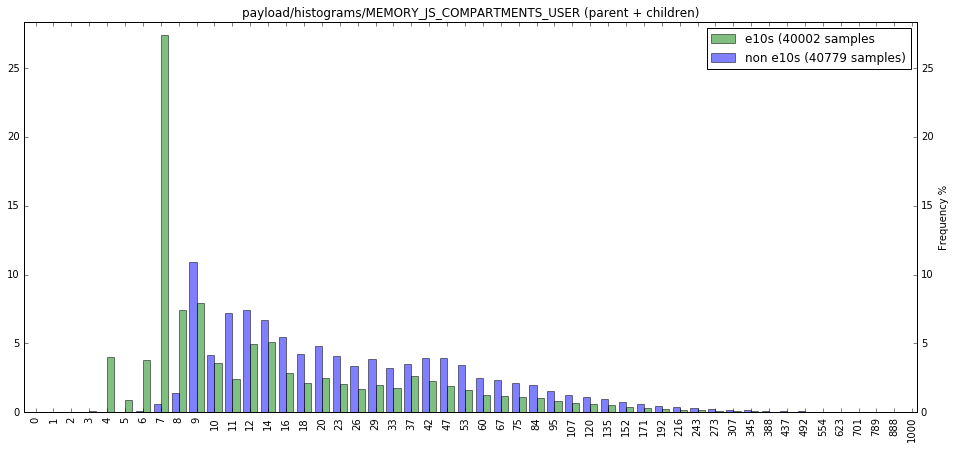

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_USER (parent + children) are differing by chance is 0.00.


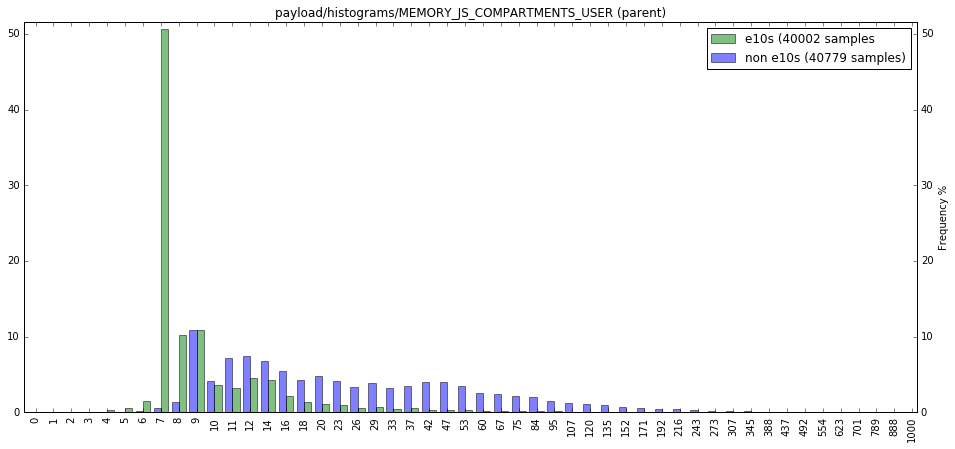

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_USER (parent) are differing by chance is 0.00.


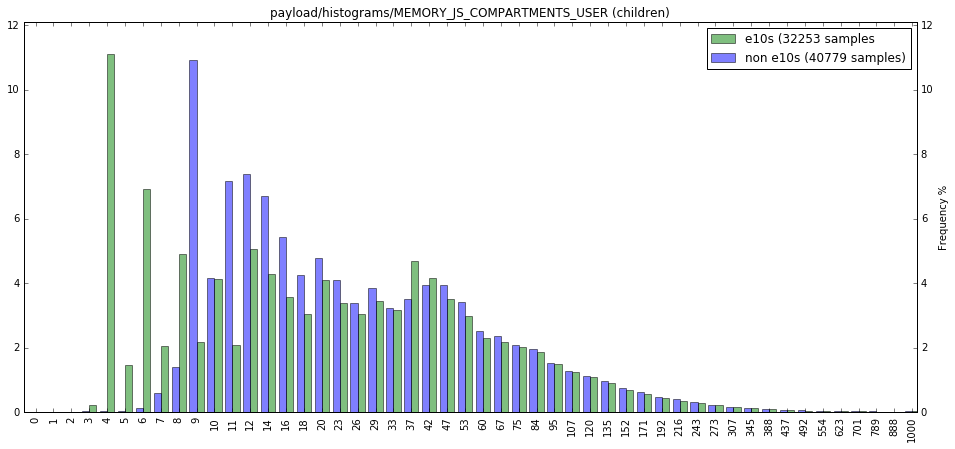

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_USER (children) are differing by chance is 0.00.


In [12]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM",
                   "payload/histograms/MEMORY_JS_COMPARTMENTS_USER")

#### d) Low memory events

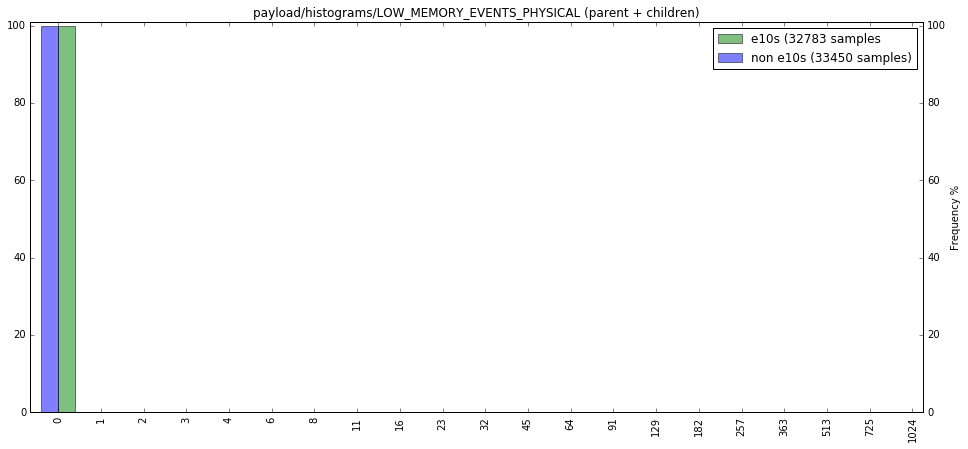

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_PHYSICAL (parent + children) are differing by chance is 1.00.


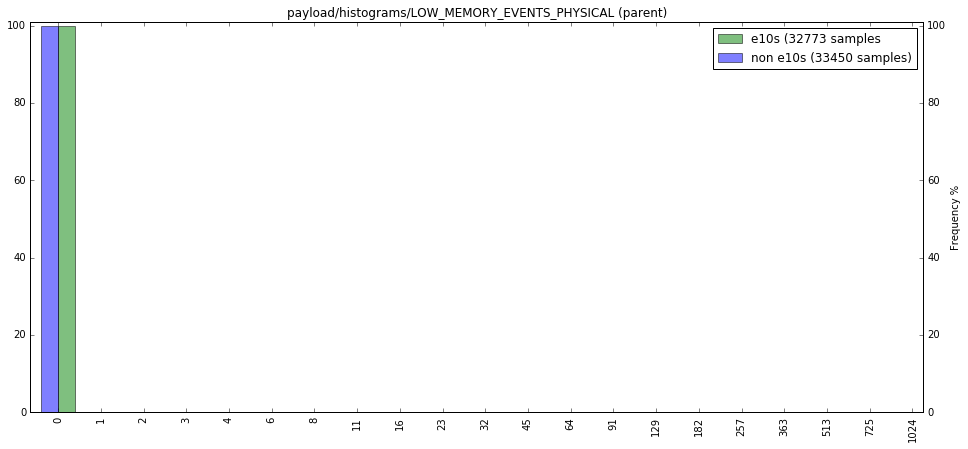

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_PHYSICAL (parent) are differing by chance is 1.00.


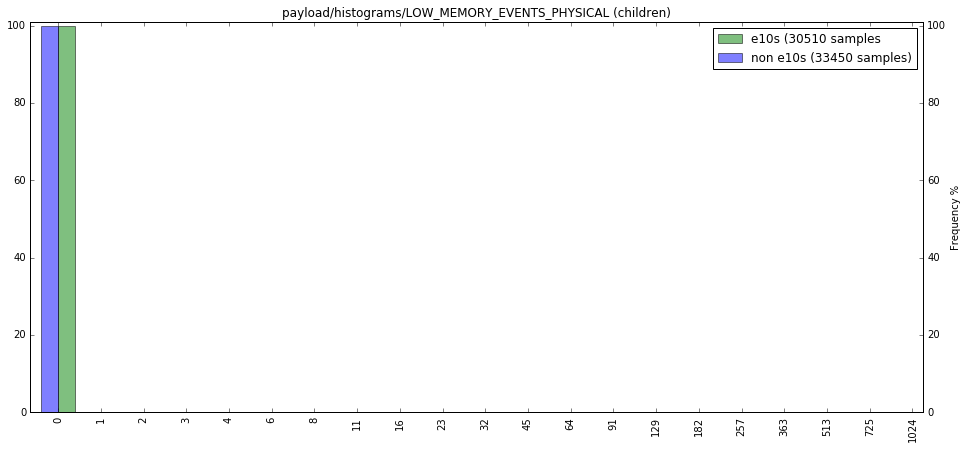

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_PHYSICAL (children) are differing by chance is 1.00.


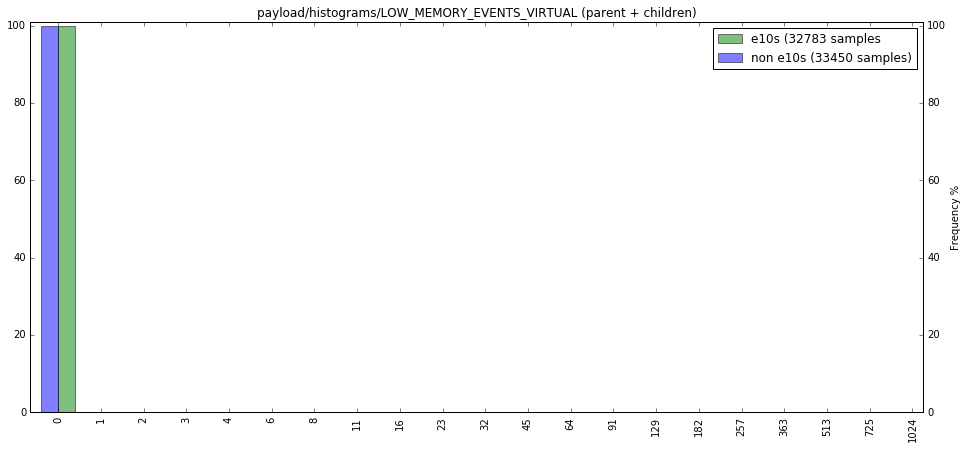

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_VIRTUAL (parent + children) are differing by chance is 0.00.


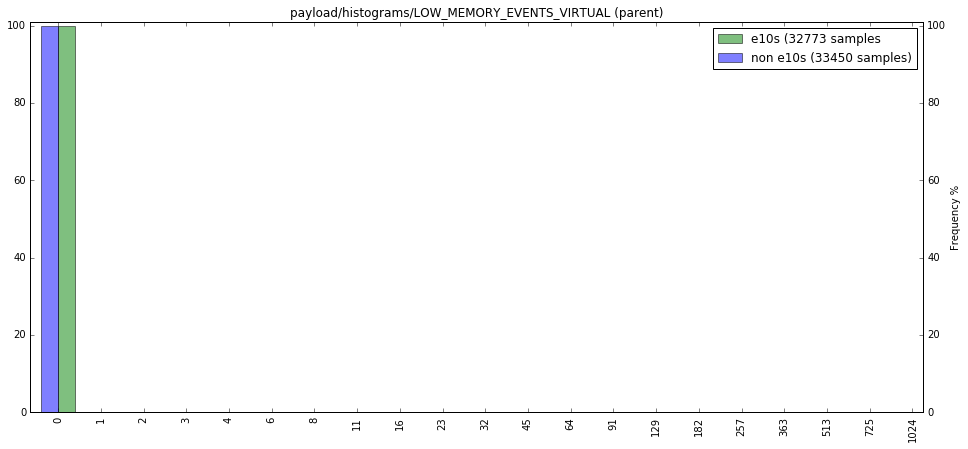

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_VIRTUAL (parent) are differing by chance is 0.00.


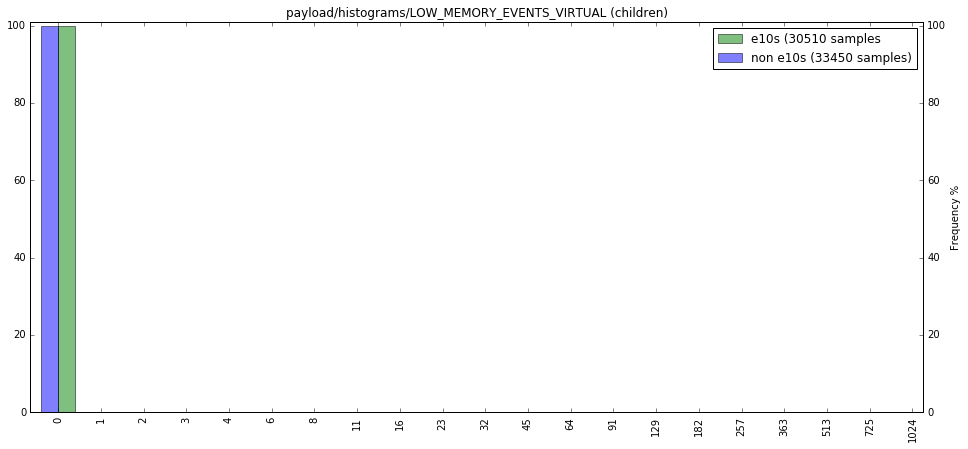

The probability that the distributions for payload/histograms/LOW_MEMORY_EVENTS_VIRTUAL (children) are differing by chance is 0.42.


In [13]:
compare_histograms(subset,
                   "payload/histograms/LOW_MEMORY_EVENTS_VIRTUAL",
                   "payload/histograms/LOW_MEMORY_EVENTS_PHYSICAL")

#### e) Page faults

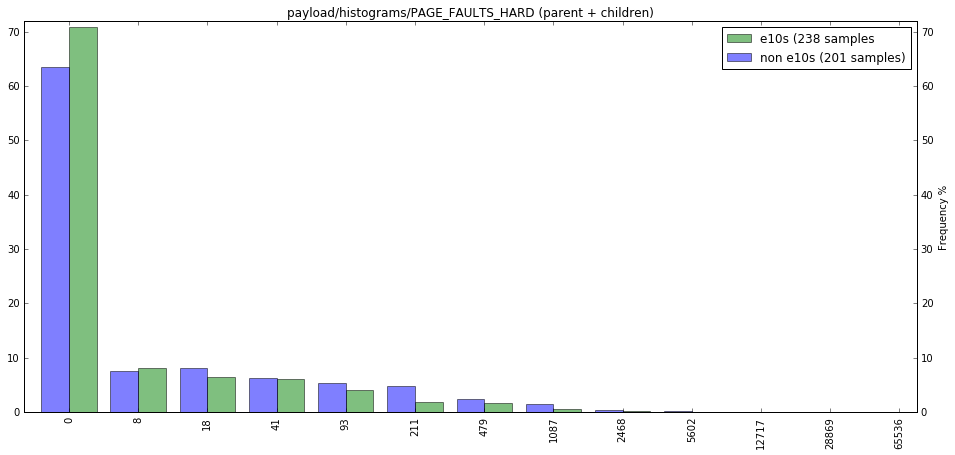

The probability that the distributions for payload/histograms/PAGE_FAULTS_HARD (parent + children) are differing by chance is 0.00.


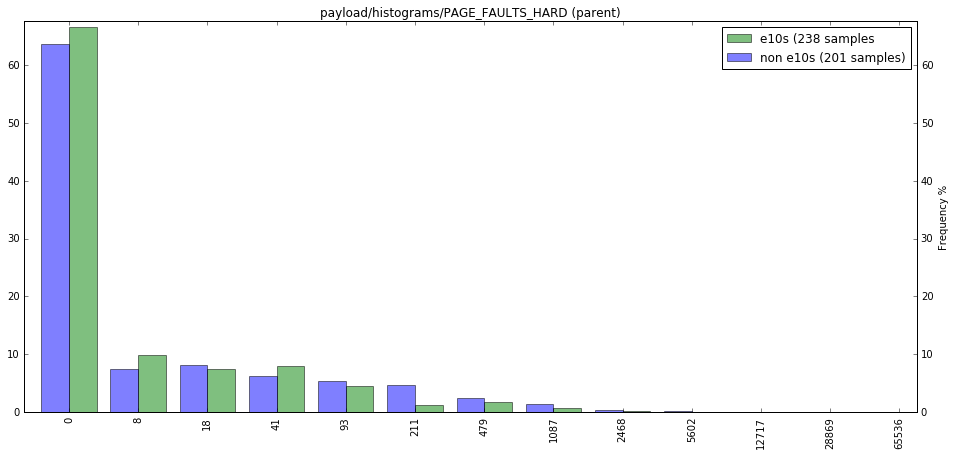

The probability that the distributions for payload/histograms/PAGE_FAULTS_HARD (parent) are differing by chance is 0.00.


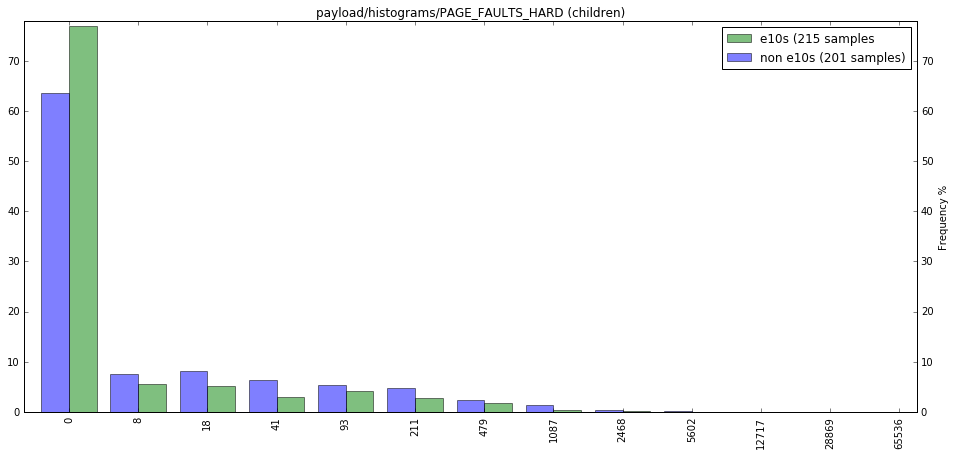

The probability that the distributions for payload/histograms/PAGE_FAULTS_HARD (children) are differing by chance is 0.00.


In [14]:
compare_histograms(subset,
                   "payload/histograms/PAGE_FAULTS_HARD")

#### f) Ghost windows

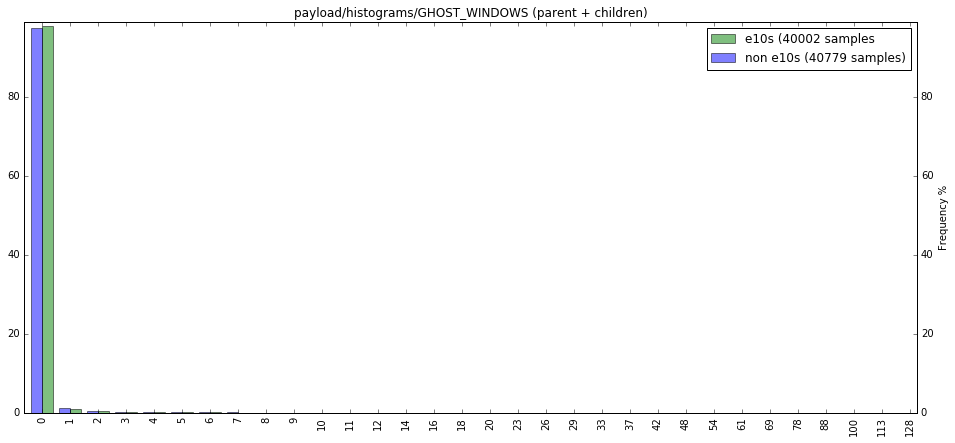

The probability that the distributions for payload/histograms/GHOST_WINDOWS (parent + children) are differing by chance is 0.00.


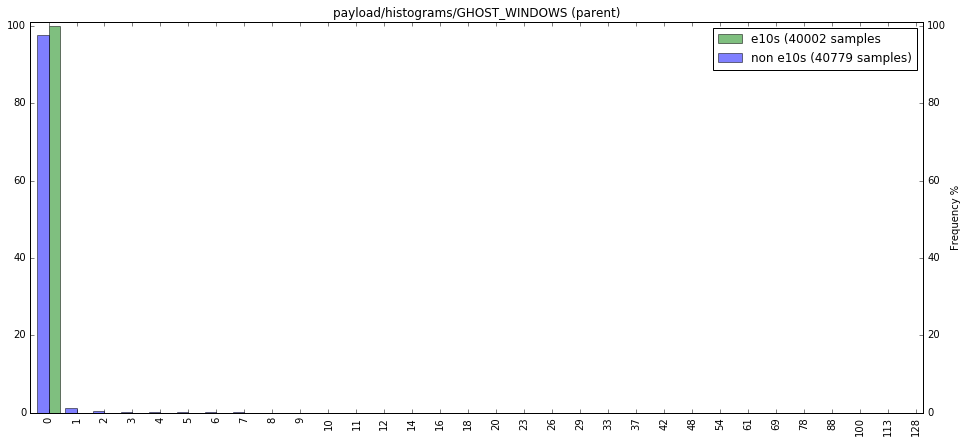

The probability that the distributions for payload/histograms/GHOST_WINDOWS (parent) are differing by chance is 0.00.


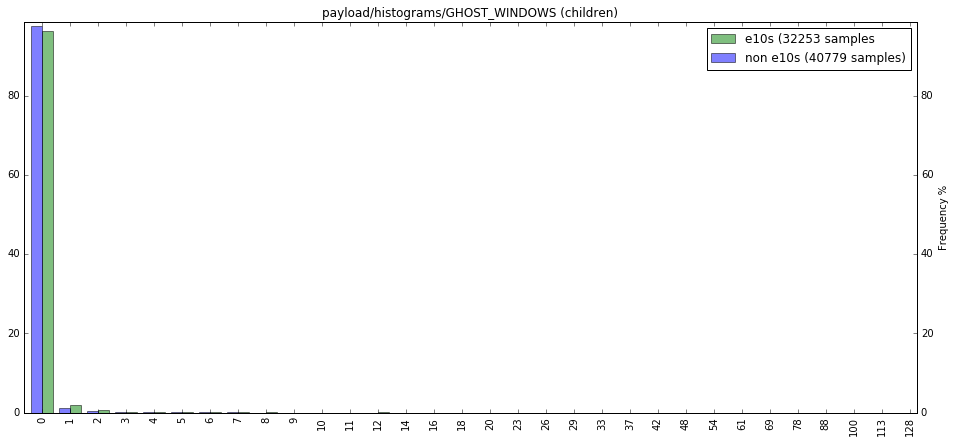

The probability that the distributions for payload/histograms/GHOST_WINDOWS (children) are differing by chance is 0.00.


In [15]:
compare_histograms(subset,
                   "payload/histograms/GHOST_WINDOWS")

## 3. Other

Differences discovered by comparing all histograms (see Bug [1198638](https://bugzilla.mozilla.org/show_bug.cgi?id=1198638))

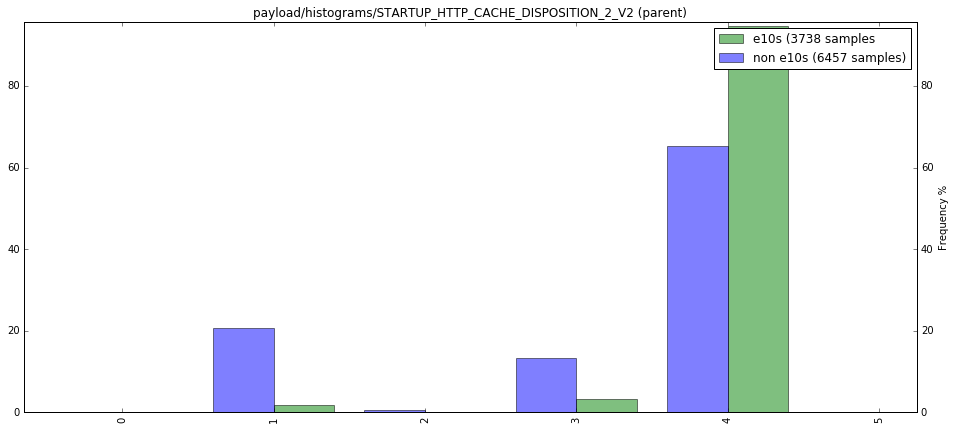

The probability that the distributions for payload/histograms/STARTUP_HTTP_CACHE_DISPOSITION_2_V2 (parent) are differing by chance is 0.00.


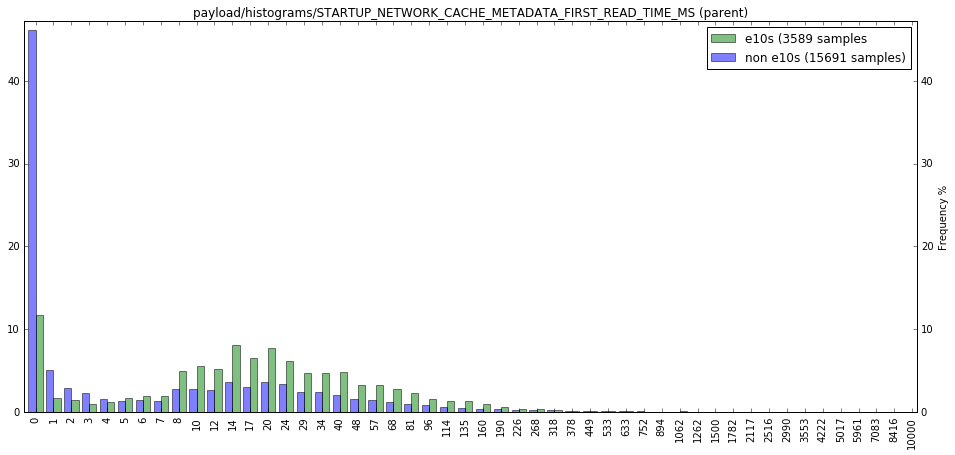

The probability that the distributions for payload/histograms/STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_TIME_MS (parent) are differing by chance is 0.00.


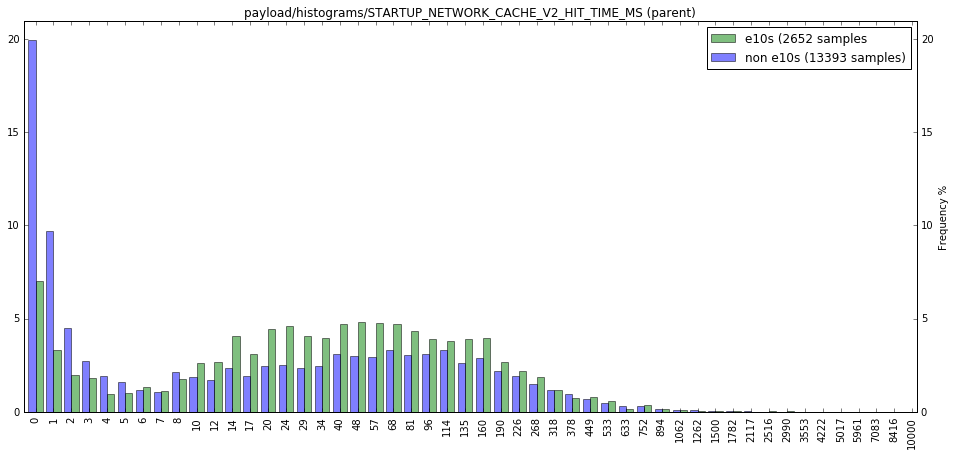

The probability that the distributions for payload/histograms/STARTUP_NETWORK_CACHE_V2_HIT_TIME_MS (parent) are differing by chance is 0.00.


In [16]:
compare_histograms(subset,
                   "payload/histograms/STARTUP_HTTP_CACHE_DISPOSITION_2_V2",
                   "payload/histograms/STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_TIME_MS",
                   "payload/histograms/STARTUP_NETWORK_CACHE_V2_HIT_TIME_MS")

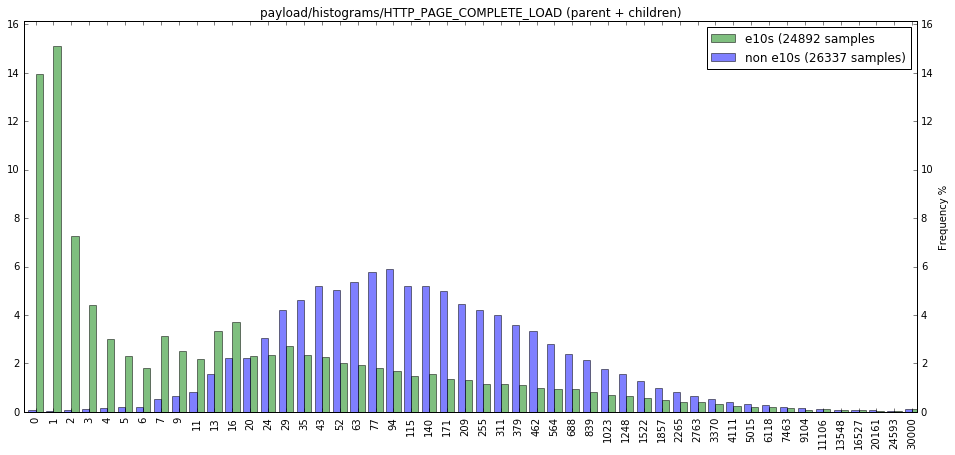

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD (parent + children) are differing by chance is 0.00.


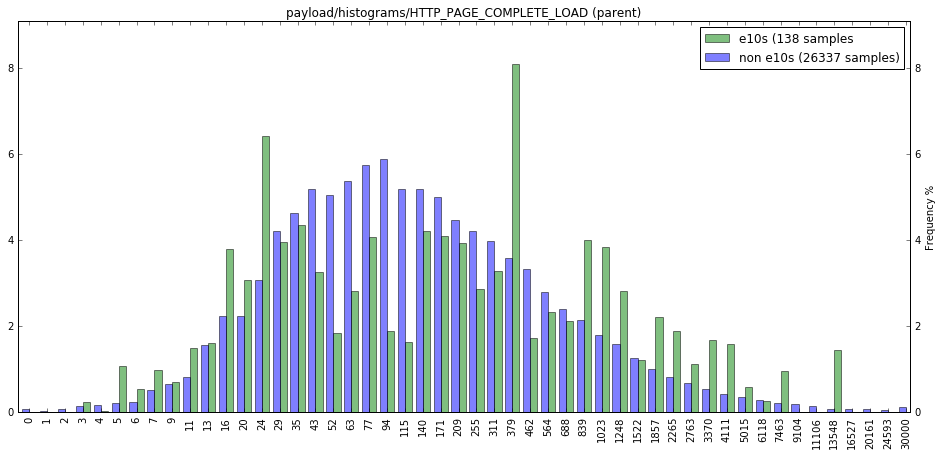

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD (parent) are differing by chance is 0.00.


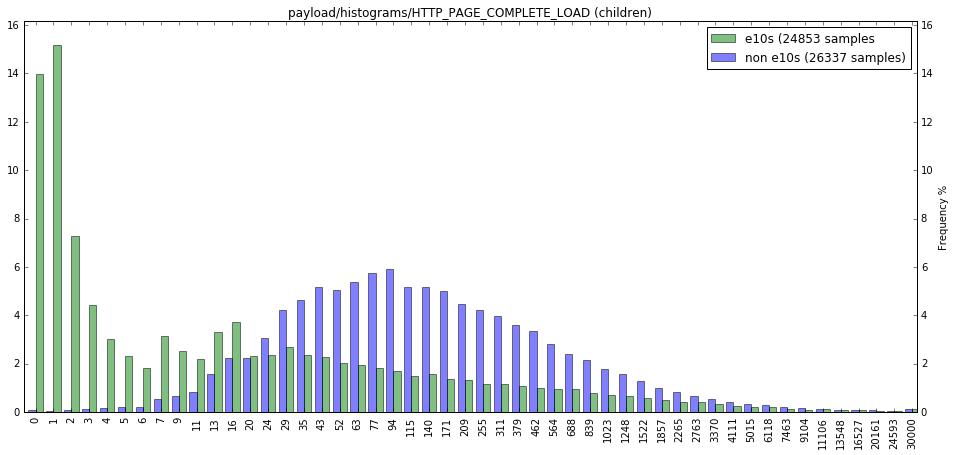

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD (children) are differing by chance is 0.00.


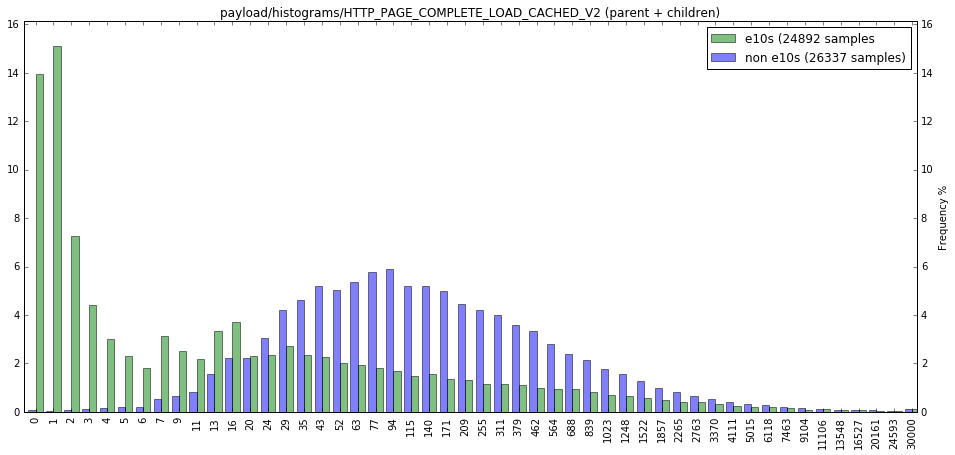

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD_CACHED_V2 (parent + children) are differing by chance is 0.00.


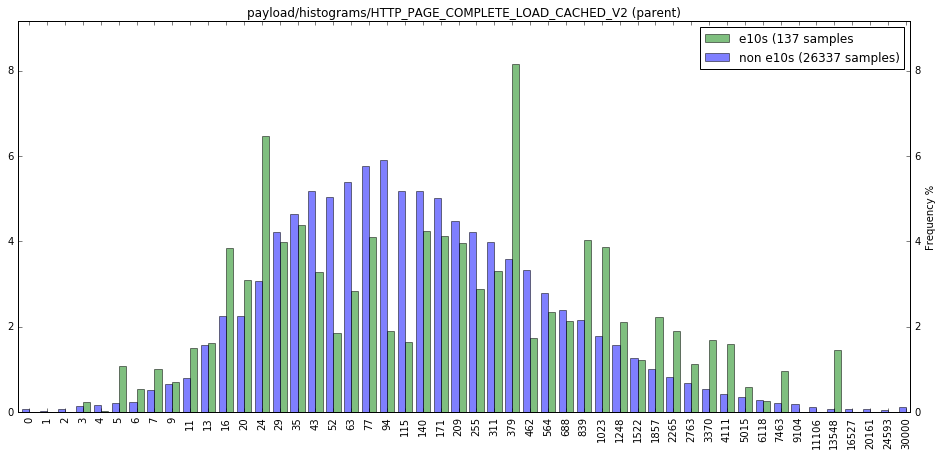

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD_CACHED_V2 (parent) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD_CACHED_V2 (children) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2 (parent + children) are differing by chance is 0.00.


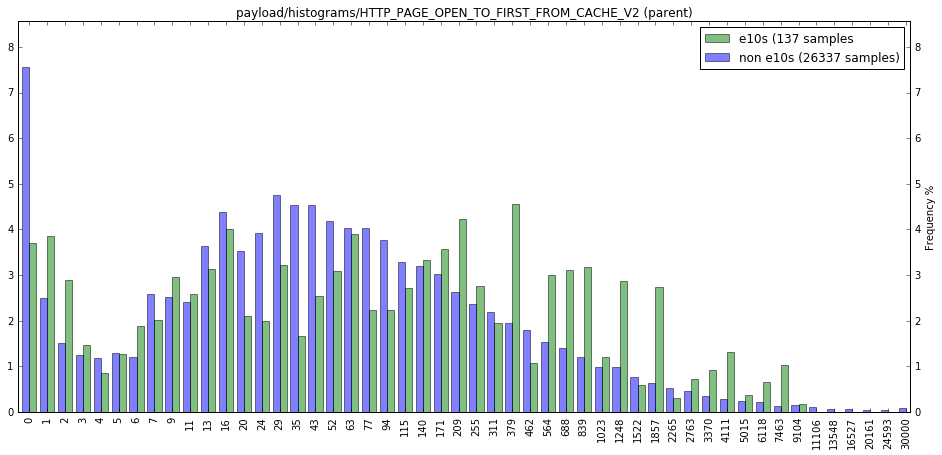

The probability that the distributions for payload/histograms/HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2 (parent) are differing by chance is 0.00.


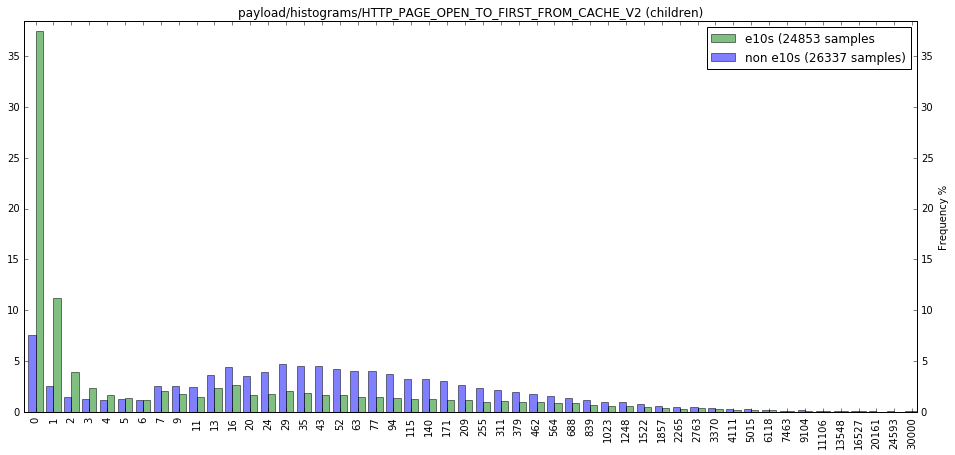

The probability that the distributions for payload/histograms/HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2 (children) are differing by chance is 0.00.


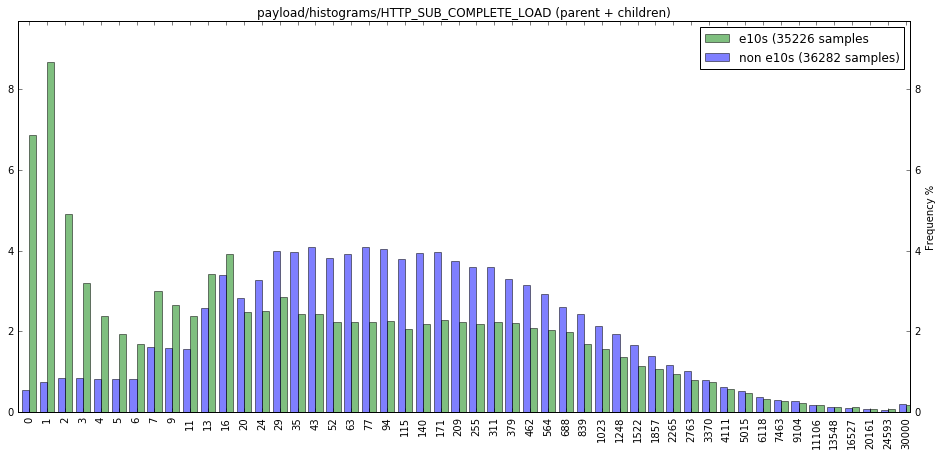

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD (parent + children) are differing by chance is 0.00.


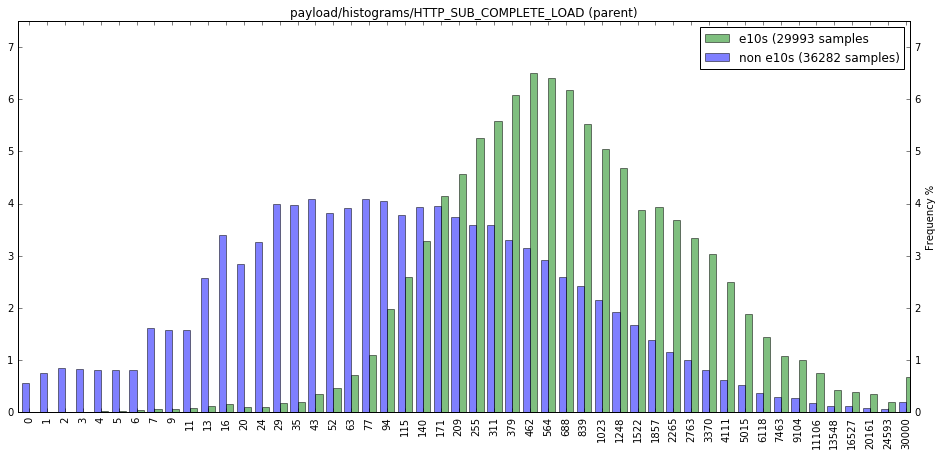

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD (parent) are differing by chance is 0.00.


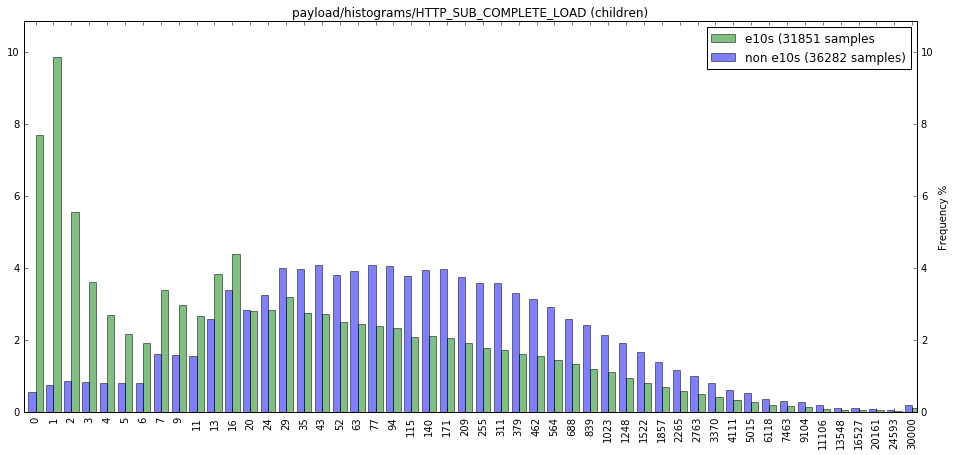

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD (children) are differing by chance is 0.00.


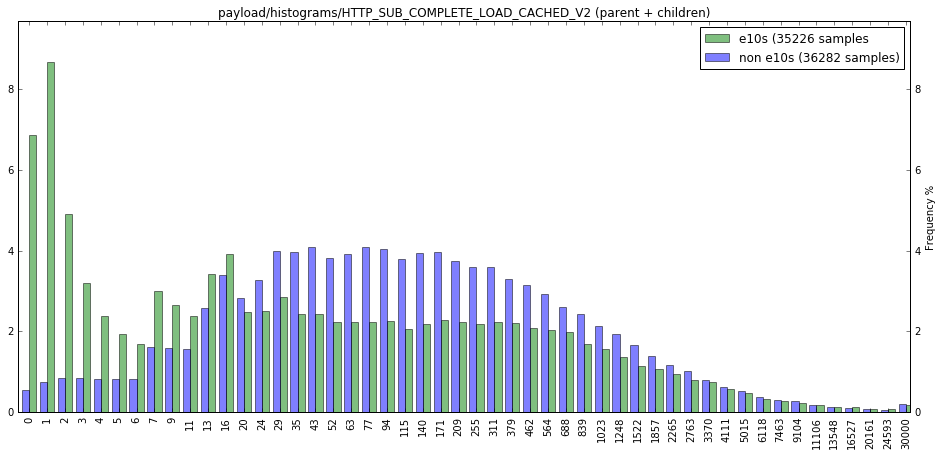

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD_CACHED_V2 (parent + children) are differing by chance is 0.00.


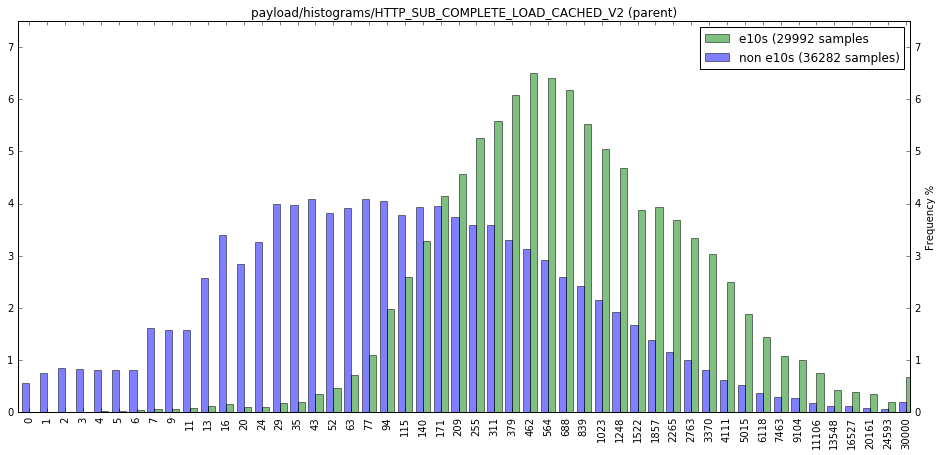

The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD_CACHED_V2 (parent) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD_CACHED_V2 (children) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2 (parent + children) are differing by chance is 0.00.


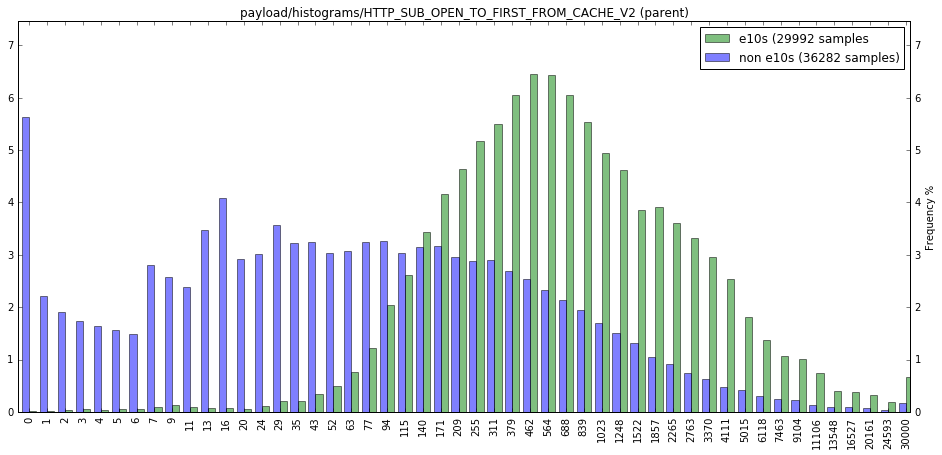

The probability that the distributions for payload/histograms/HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2 (parent) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2 (children) are differing by chance is 0.00.


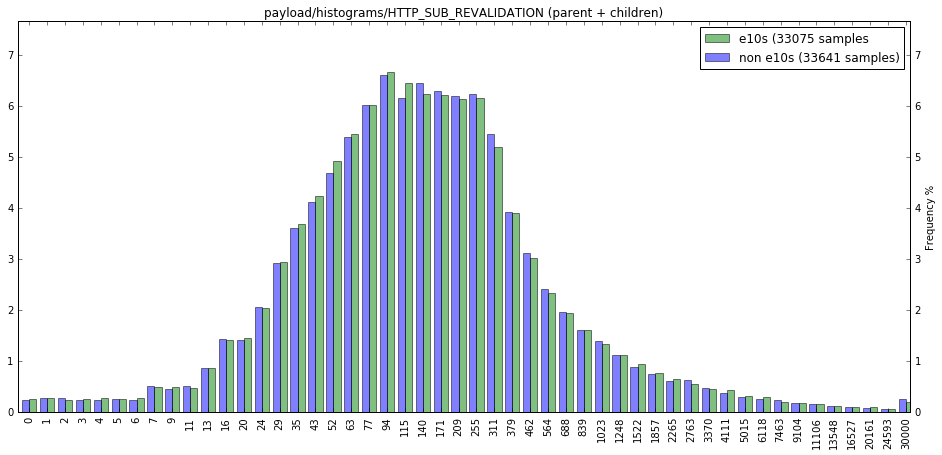

The probability that the distributions for payload/histograms/HTTP_SUB_REVALIDATION (parent + children) are differing by chance is 0.11.


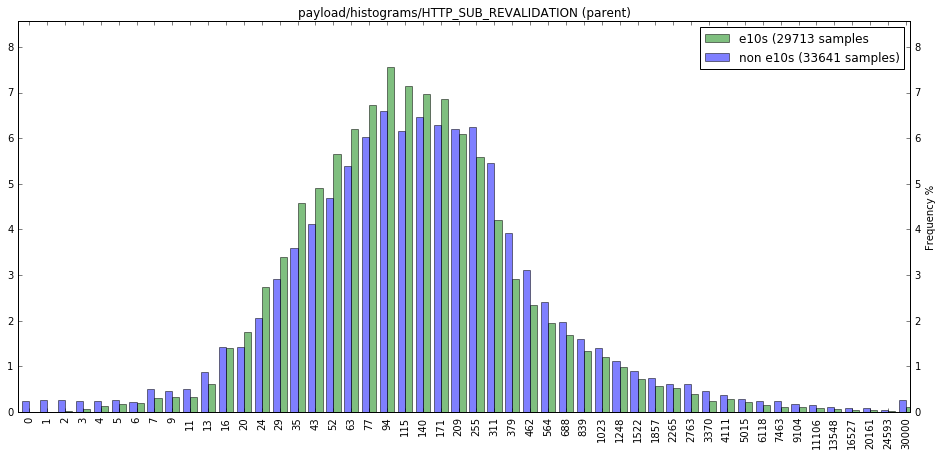

The probability that the distributions for payload/histograms/HTTP_SUB_REVALIDATION (parent) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/HTTP_SUB_REVALIDATION (children) are differing by chance is 0.00.


In [17]:
compare_histograms(subset,
                   "payload/histograms/HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2",
                   "payload/histograms/HTTP_PAGE_COMPLETE_LOAD_CACHED_V2",
                   "payload/histograms/HTTP_PAGE_COMPLETE_LOAD",
                   "payload/histograms/HTTP_SUB_COMPLETE_LOAD_CACHED_V2",
                   "payload/histograms/HTTP_SUB_COMPLETE_LOAD",                   
                   "payload/histograms/HTTP_SUB_REVALIDATION",
                   "payload/histograms/HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2")

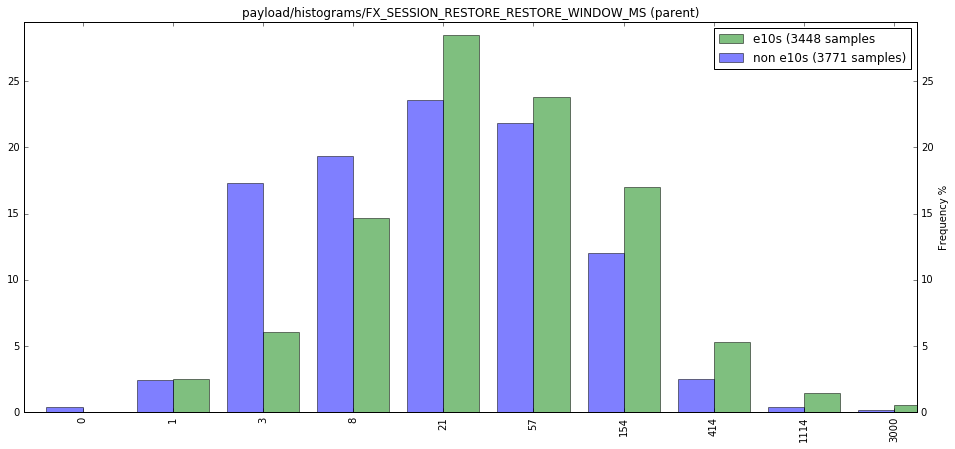

The probability that the distributions for payload/histograms/FX_SESSION_RESTORE_RESTORE_WINDOW_MS (parent) are differing by chance is 0.00.


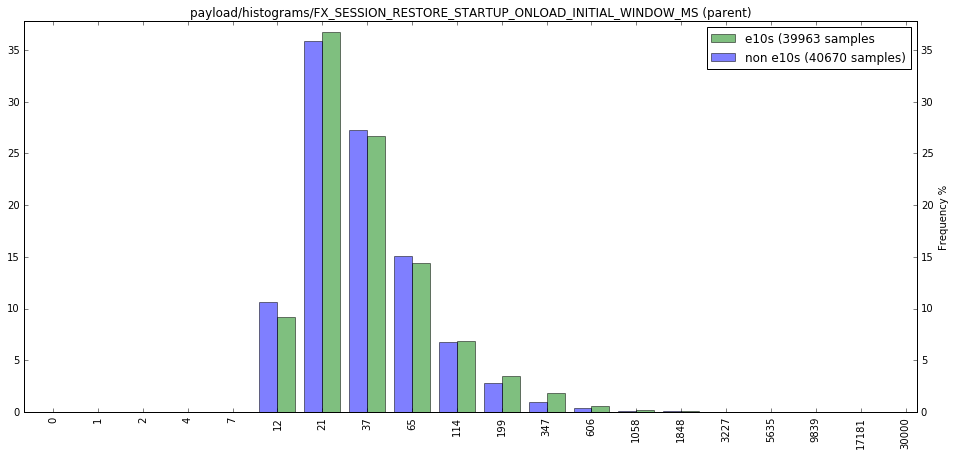

The probability that the distributions for payload/histograms/FX_SESSION_RESTORE_STARTUP_ONLOAD_INITIAL_WINDOW_MS (parent) are differing by chance is 0.00.


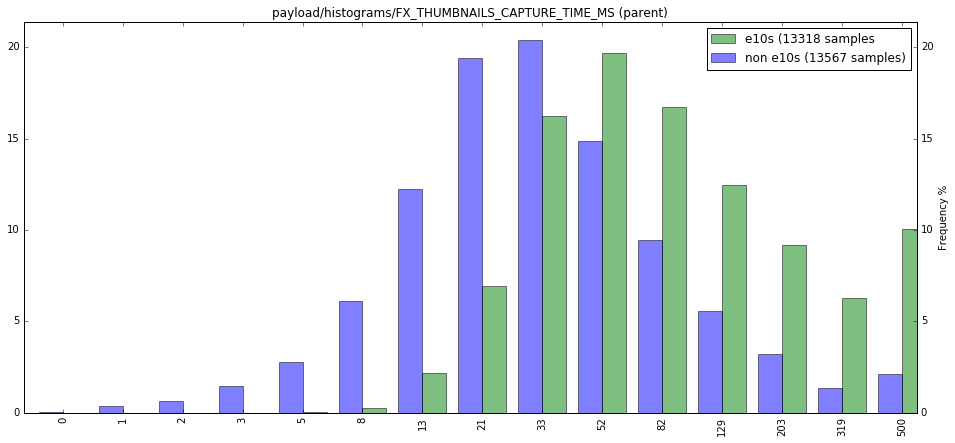

The probability that the distributions for payload/histograms/FX_THUMBNAILS_CAPTURE_TIME_MS (parent) are differing by chance is 0.00.


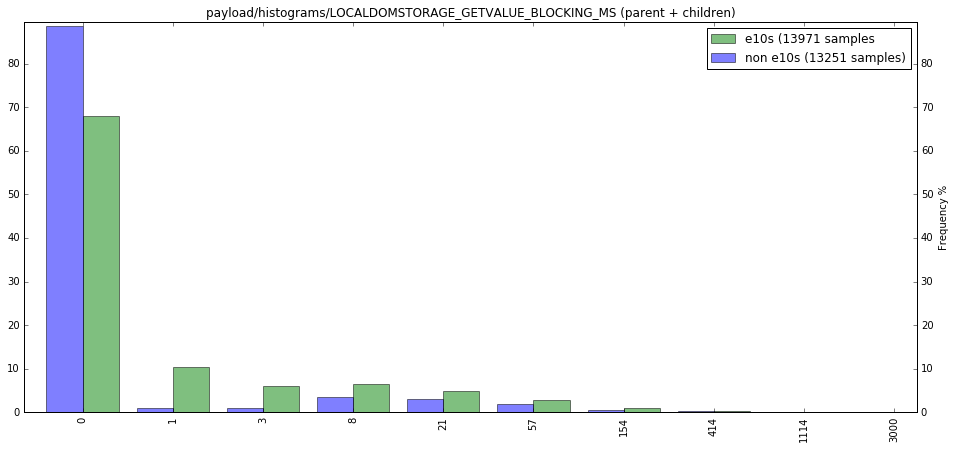

The probability that the distributions for payload/histograms/LOCALDOMSTORAGE_GETVALUE_BLOCKING_MS (parent + children) are differing by chance is 0.00.


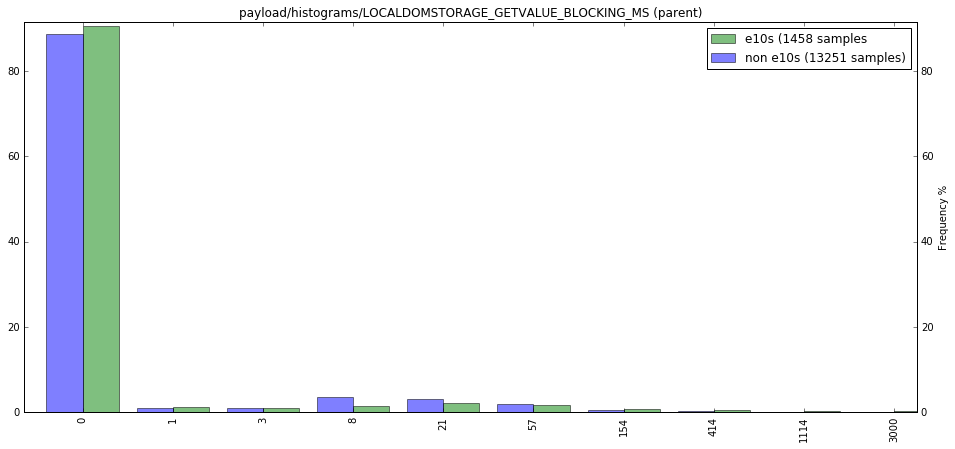

The probability that the distributions for payload/histograms/LOCALDOMSTORAGE_GETVALUE_BLOCKING_MS (parent) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/LOCALDOMSTORAGE_GETVALUE_BLOCKING_MS (children) are differing by chance is 0.00.


In [18]:
compare_histograms(subset, 
                   "payload/histograms/FX_THUMBNAILS_CAPTURE_TIME_MS",                   
                   "payload/histograms/LOCALDOMSTORAGE_GETVALUE_BLOCKING_MS",
                   "payload/histograms/FX_SESSION_RESTORE_RESTORE_WINDOW_MS",
                   "payload/histograms/FX_SESSION_RESTORE_STARTUP_ONLOAD_INITIAL_WINDOW_MS")

The probability that the distributions for payload/histograms/AUDIOSTREAM_FIRST_OPEN_MS (parent + children) are differing by chance is 0.75.


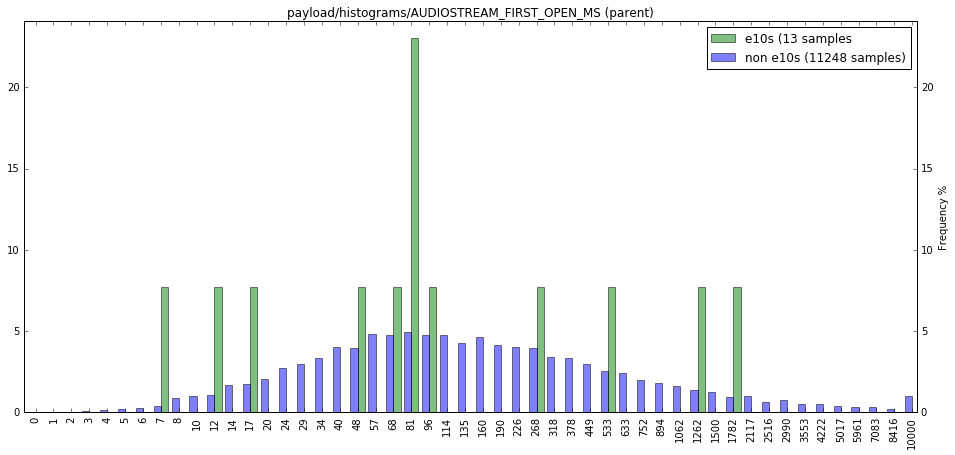

The probability that the distributions for payload/histograms/AUDIOSTREAM_FIRST_OPEN_MS (parent) are differing by chance is 0.19.


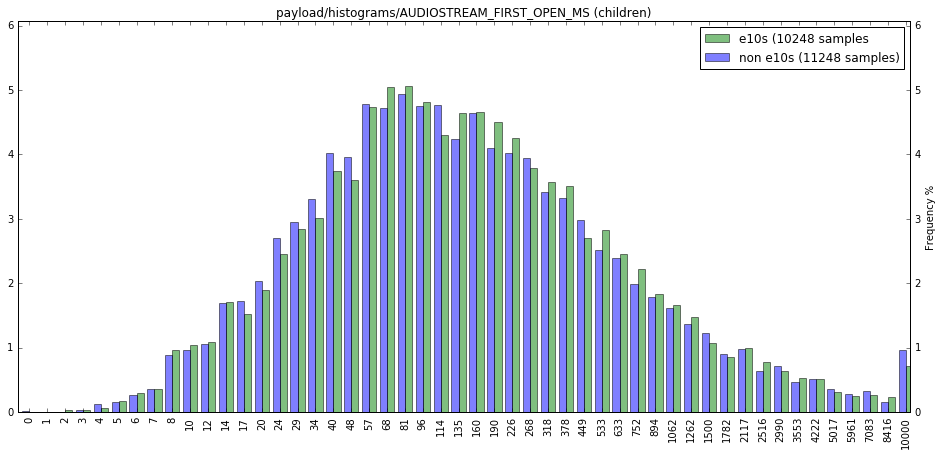

The probability that the distributions for payload/histograms/AUDIOSTREAM_FIRST_OPEN_MS (children) are differing by chance is 0.80.


The probability that the distributions for payload/histograms/AUDIOSTREAM_LATER_OPEN_MS (parent + children) are differing by chance is 0.00.


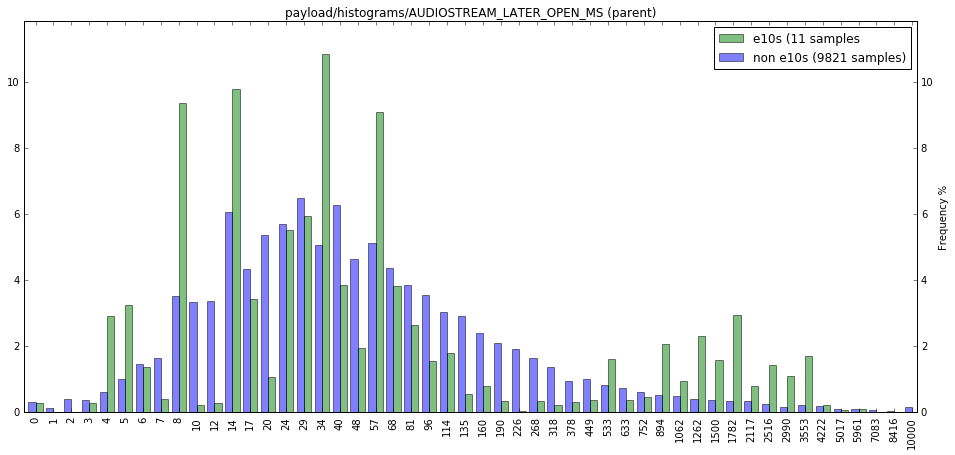

The probability that the distributions for payload/histograms/AUDIOSTREAM_LATER_OPEN_MS (parent) are differing by chance is 0.38.


The probability that the distributions for payload/histograms/AUDIOSTREAM_LATER_OPEN_MS (children) are differing by chance is 0.00.


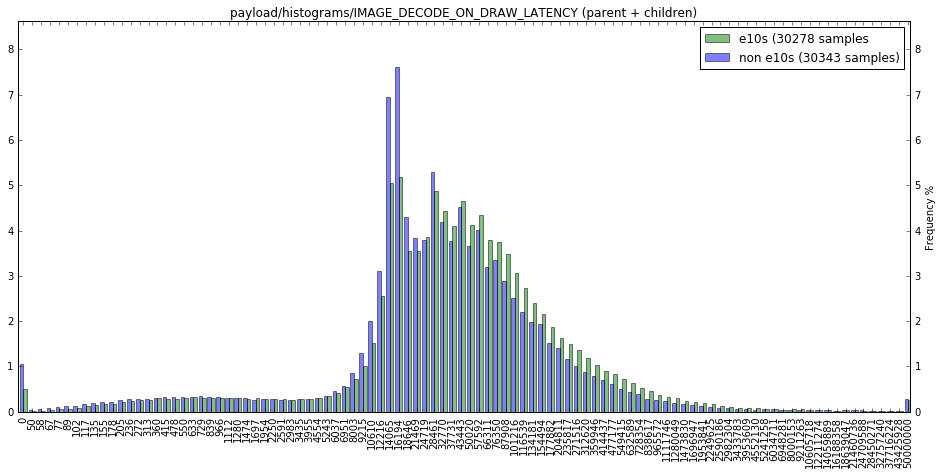

The probability that the distributions for payload/histograms/IMAGE_DECODE_ON_DRAW_LATENCY (parent + children) are differing by chance is 0.00.


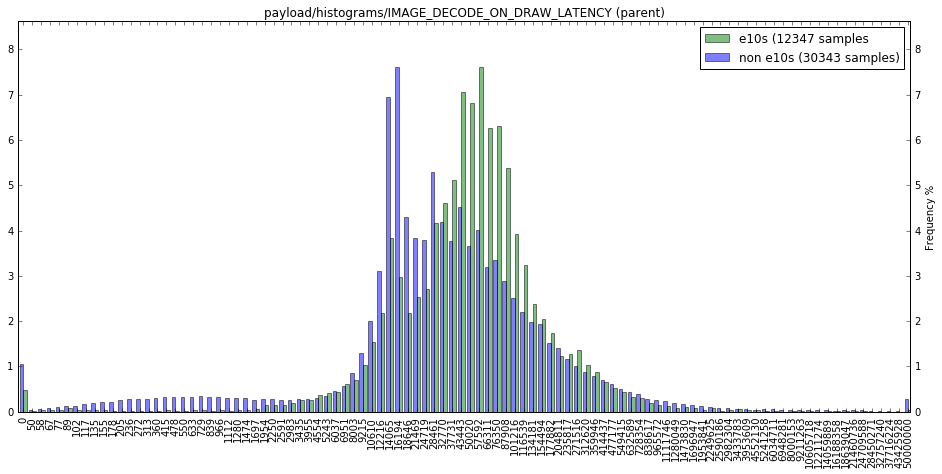

The probability that the distributions for payload/histograms/IMAGE_DECODE_ON_DRAW_LATENCY (parent) are differing by chance is 0.00.


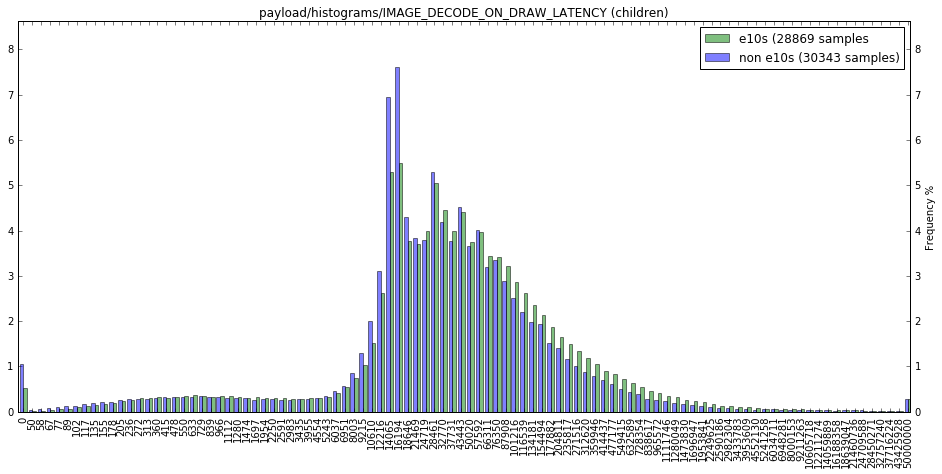

The probability that the distributions for payload/histograms/IMAGE_DECODE_ON_DRAW_LATENCY (children) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/IMAGE_DECODE_SPEED_GIF (parent + children) are differing by chance is 0.00.


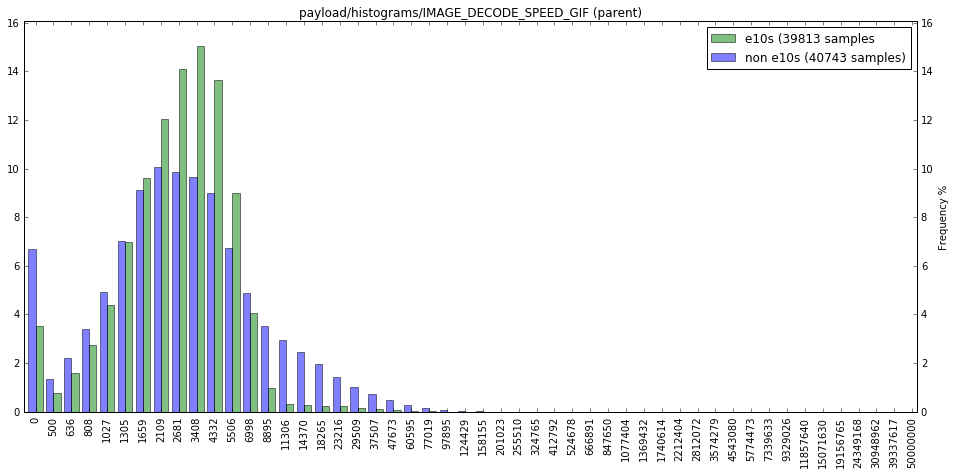

The probability that the distributions for payload/histograms/IMAGE_DECODE_SPEED_GIF (parent) are differing by chance is 0.00.


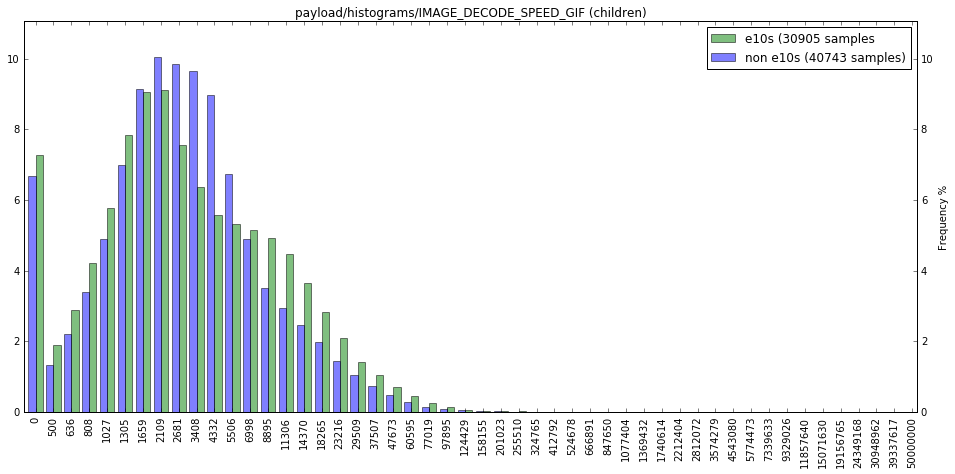

The probability that the distributions for payload/histograms/IMAGE_DECODE_SPEED_GIF (children) are differing by chance is 0.00.


In [19]:
compare_histograms(subset, 
                   "payload/histograms/IMAGE_DECODE_ON_DRAW_LATENCY",
                   "payload/histograms/IMAGE_DECODE_SPEED_GIF",
                   "payload/histograms/AUDIOSTREAM_LATER_OPEN_MS",
                   "payload/histograms/AUDIOSTREAM_FIRST_OPEN_MS")

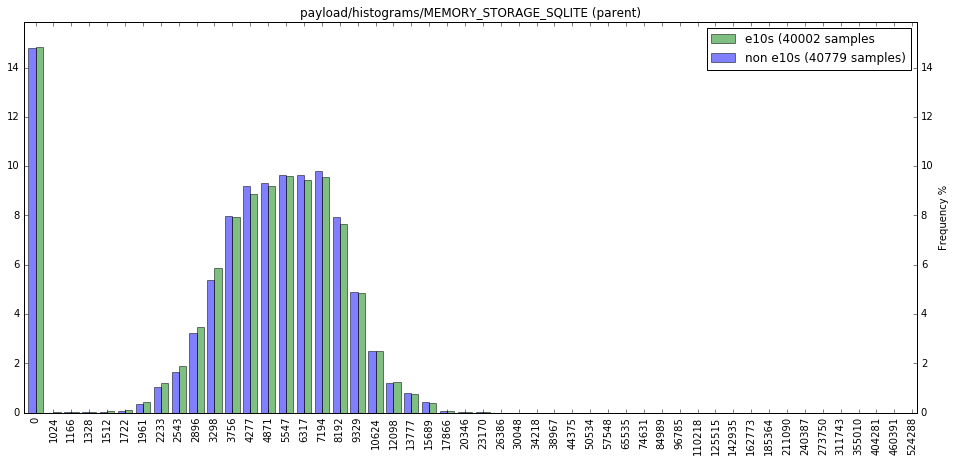

The probability that the distributions for payload/histograms/MEMORY_STORAGE_SQLITE (parent) are differing by chance is 0.00.


In [20]:
compare_histograms(subset, 
                   "payload/histograms/MEMORY_STORAGE_SQLITE",
                   "payload/histograms/BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS")

The probability that the distributions for payload/histograms/CERT_VALIDATION_HTTP_REQUEST_CANCELED_TIME (parent) are differing by chance is 0.00.


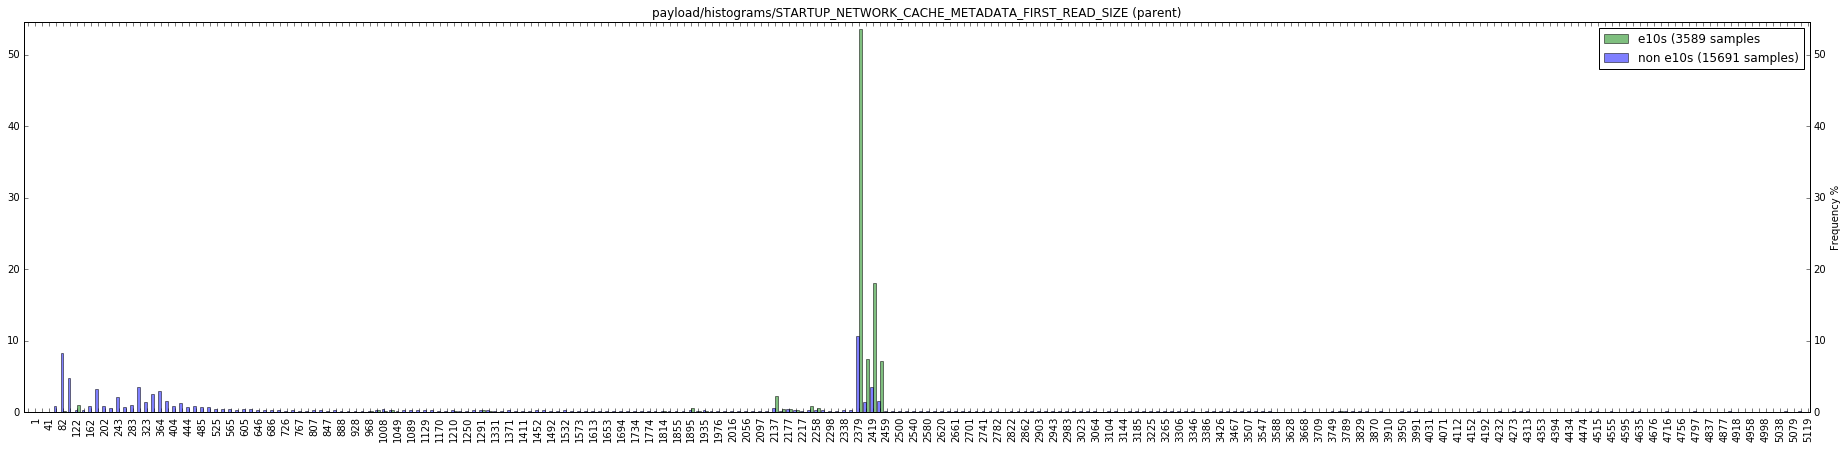

The probability that the distributions for payload/histograms/STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_SIZE (parent) are differing by chance is 0.00.


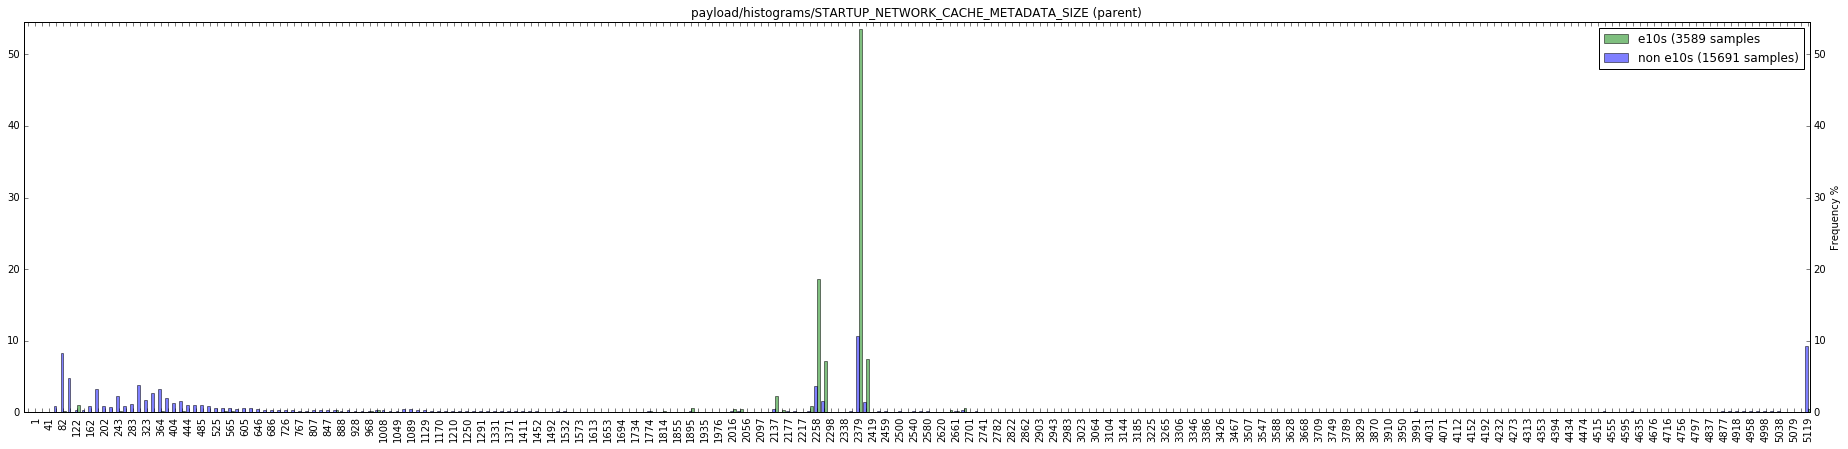

The probability that the distributions for payload/histograms/STARTUP_NETWORK_CACHE_METADATA_SIZE (parent) are differing by chance is 0.00.


In [21]:
IPython.core.pylabtools.figsize(32, 7)
compare_histograms(subset, 
                   "payload/histograms/CERT_VALIDATION_HTTP_REQUEST_CANCELED_TIME",
                   "payload/histograms/STARTUP_NETWORK_CACHE_METADATA_SIZE",
                   "payload/histograms/STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_SIZE")
IPython.core.pylabtools.figsize(16, 7)

**bug 1226564** - please compare `HTTP_*_COMPLETE_LOAD_NET_V2`

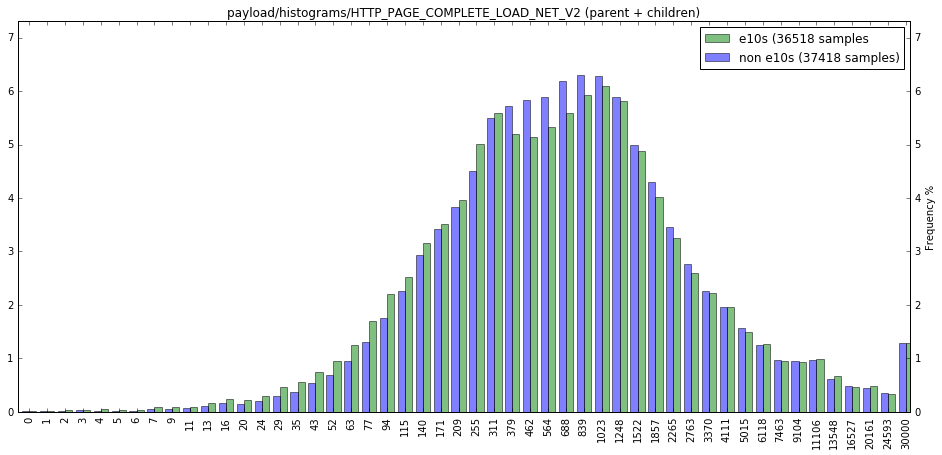

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD_NET_V2 (parent + children) are differing by chance is 0.00.


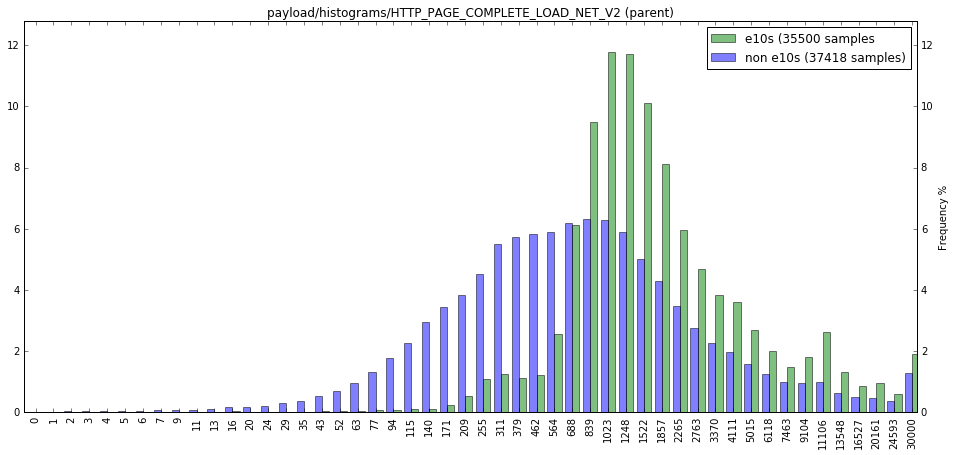

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD_NET_V2 (parent) are differing by chance is 0.00.


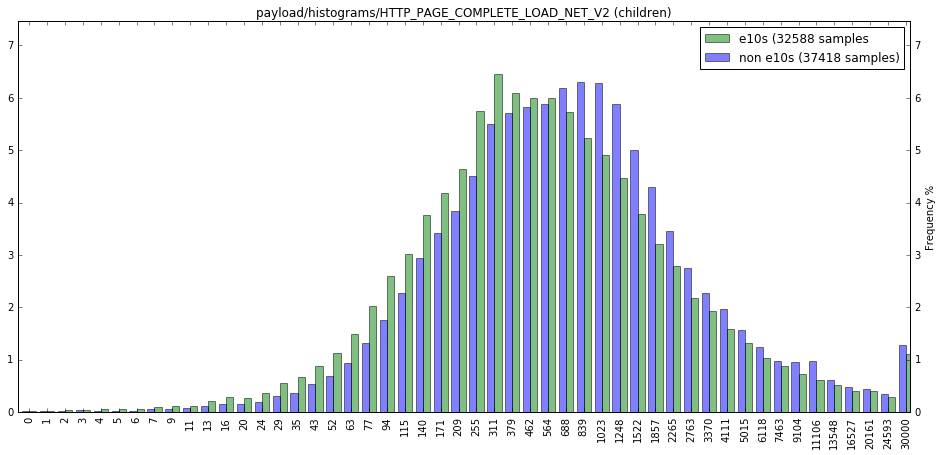

The probability that the distributions for payload/histograms/HTTP_PAGE_COMPLETE_LOAD_NET_V2 (children) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD_NET_V2 (parent + children) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD_NET_V2 (parent) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/HTTP_SUB_COMPLETE_LOAD_NET_V2 (children) are differing by chance is 0.00.


In [22]:
compare_histograms(subset,
                   "payload/histograms/HTTP_PAGE_COMPLETE_LOAD_NET_V2",
                   "payload/histograms/HTTP_SUB_COMPLETE_LOAD_NET_V2")

**bug 1255159** - Please look at FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS

In [23]:
compare_histograms(subset, "payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS")

The probability that the distributions for payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS (parent + children) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS (parent) are differing by chance is 0.00.


The probability that the distributions for payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS (children) are differing by chance is 0.00.


**bug 1273847** - Please look at SLOW_SCRIPT_NOTIFY_DELAY, SHUTDOWN_OK

The probability that the distributions for payload/histograms/SLOW_SCRIPT_NOTIFY_DELAY (parent + children) are differing by chance is 0.00.


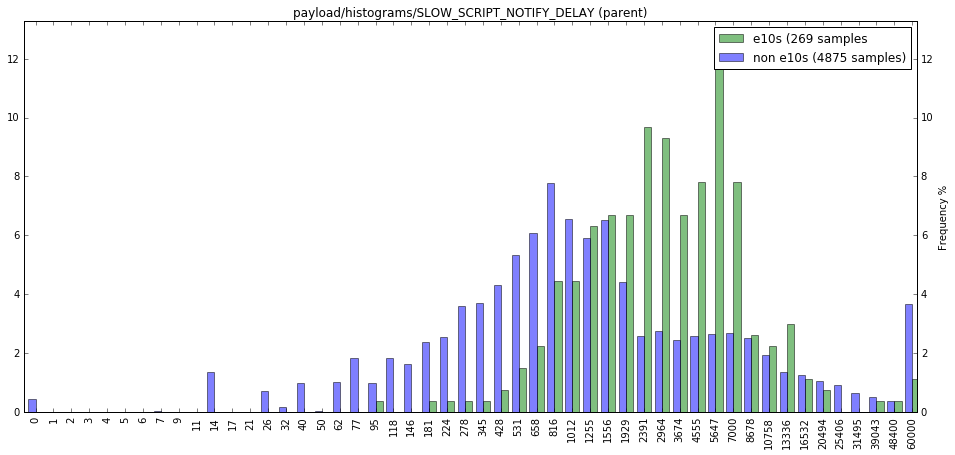

The probability that the distributions for payload/histograms/SLOW_SCRIPT_NOTIFY_DELAY (parent) are differing by chance is 0.00.


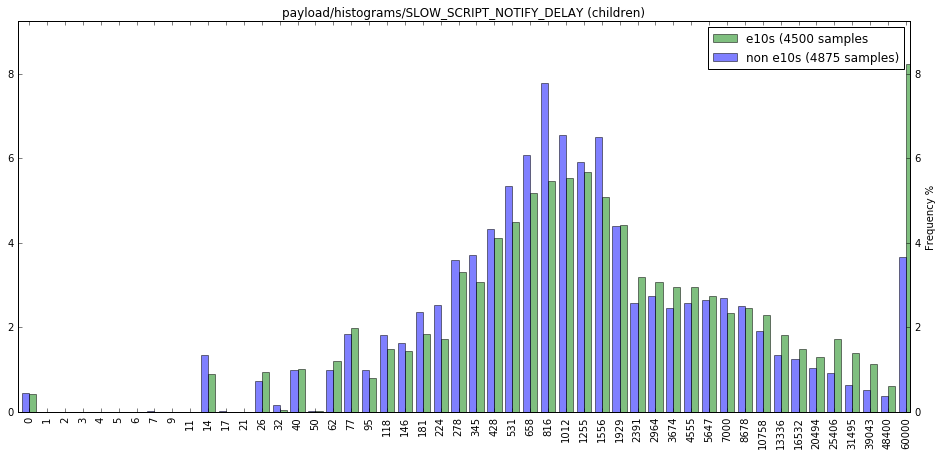

The probability that the distributions for payload/histograms/SLOW_SCRIPT_NOTIFY_DELAY (children) are differing by chance is 0.00.


In [24]:
compare_histograms(big_subset, "payload/histograms/SLOW_SCRIPT_NOTIFY_DELAY")

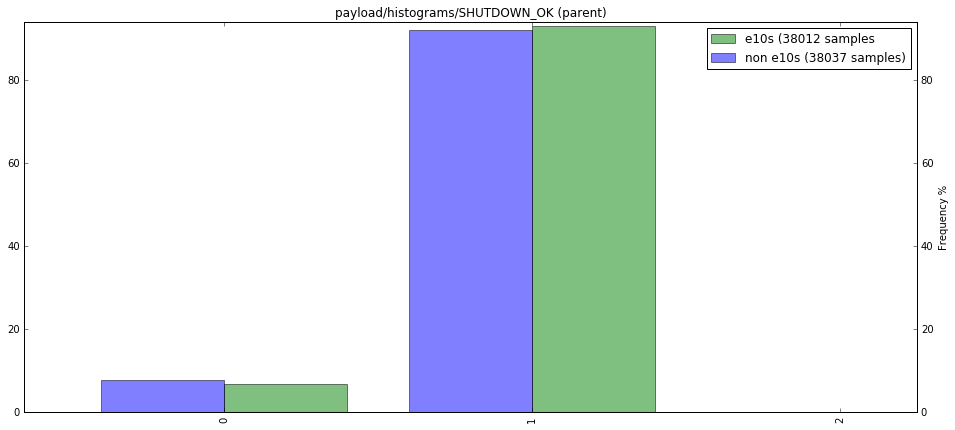

The probability that the distributions for payload/histograms/SHUTDOWN_OK (parent) are differing by chance is 0.00.


In [25]:
compare_histograms(subset, "payload/histograms/SHUTDOWN_OK")